## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-normal_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\normal_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


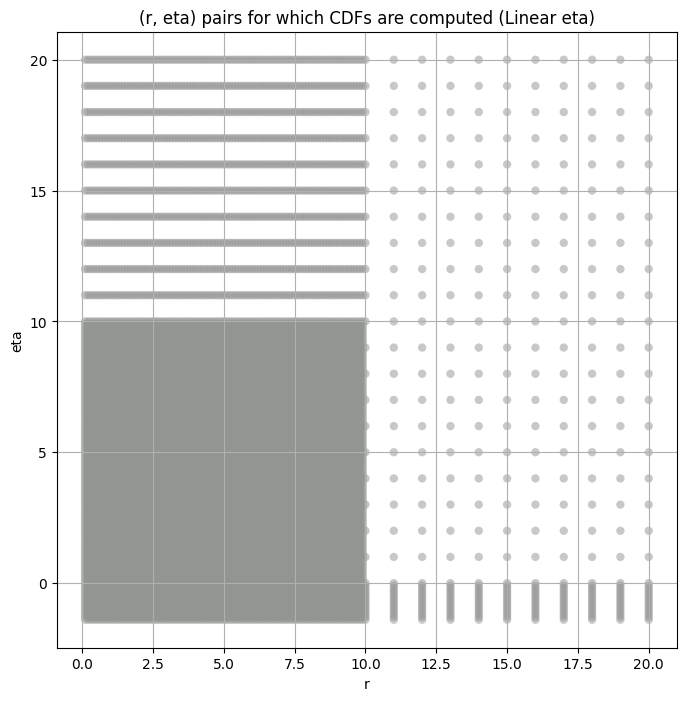

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     1.177774e+09  1.085649e+09  1.276239e+09   7.888103    6.781435   
5     2.880509e+09  2.718593e+09  3.046499e+09   2.915701    2.525911   
8     1.827356e+09  1.720742e+09  1.937364e+09   3.388295    2.926564   
11    1.390924e+09  1.312385e+09  1.470517e+09   2.917553    2.612940   
14    2.921197e+08  2.674729e+08  3.178738e+08   9.318104    8.035010   
18    5.415066e+07  4.980312e+07  5.888757e+07   8.531016    6.306366   
21    2.395606e+07  2.142995e+07  2.678720e+07  16.482788   11.398751   
24    1.826045e+07  1.571240e+07  2.106897e+07  30.356003   24.832960   
27    8.273984e+06  6.927880e+06  9.753366e+06  42.051674   34.199646   
31    2.400116e+05  1.916386e+05  3.022838e+05  75.993420   46.090584   

      kurt_upper  total_samples  
band                             
2       9.279733     57824238.0  
5       3.333546     57824238.0  
8       3.872236     57824238.0  
11      3.238348     57824238.0  
14     10.718221     57824238.0  
18     12.651335     57824238.0  
21     25.385132     57824238.0  
24     36.771297     57824238.0  
27     51.289660     57824238.0  
31    178.931350     57824238.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     1.177774e+09   1.177774e+09    1.149718e+09    1.129415e+09   
5     2.880509e+09   2.880509e+09    2.844121e+09    2.813727e+09   
8     1.827356e+09   1.827356e+09    1.802211e+09    1.780453e+09   
11    1.390924e+09   1.390924e+09    1.376875e+09    1.364520e+09   
14    2.921197e+08   2.921197e+08    2.845362e+08    2.785337e+08   
18    5.415066e+07   5.415066e+07    5.233879e+07    5.116978e+07   
21    2.395606e+07   2.395606e+07    2.271626e+07    2.194883e+07   
24    1.826045e+07   1.826045e+07    1.716976e+07    1.635967e+07   
27    8.273984e+06   8.273984e+06    7.668714e+06    7.220857e+06   
31    2.400116e+05   2.400116e+05    2.116453e+05    1.952757e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.111565e+09     1.095233e+09     1.065668e+09     1.039042e+09   
5       2.786255e+09     2.760732e+09     2.713779e+09     2.670843e+09   
8       1.760713e+09     1.742527e+09     1.709589e+09     1.679981e+09   
11      1.353003e+09     1.342072e+09     1.321520e+09     1.302300e+09   
14      2.732323e+08     2.683971e+08     2.597110e+08     2.519737e+08   
18      5.019999e+07     4.935239e+07     4.789372e+07     4.664541e+07   
21      2.133005e+07     2.080174e+07     1.991944e+07     1.919069e+07   
24      1.567272e+07     1.506795e+07     1.403069e+07     1.315599e+07   
27      6.844648e+06     6.516590e+06     5.960229e+06     5.497548e+06   
31      1.821500e+05     1.710860e+05     1.531306e+05     1.389044e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.014627e+09     9.919089e+08     9.705531e+08     9.128239e+08  
5        2.630926e+09     2.593445e+09     2.557989e+09     2.461038e+09  
8        1.652821e+09     1.627573e+09     1.603862e+09     1.539613e+09  
11       1.284120e+09     1.266799e+09     1.250205e+09     1.203955e+09  
14       2.449429e+08     2.384728e+08     2.324617e+08     2.165516e+08  
18       4.554273e+07     4.454805e+07     4.363718e+07     4.126410e+07  
21       1.856528e+07     1.801347e+07     1.751572e+07     1.624627e+07  
24       1.239835e+07     1.173001e+07     1.113280e+07     9.658326e+06  
27       5.101794e+06     4.757081e+06     4.452586e+06     3.714665e+06  
31       1.271895e+05     1.172959e+05     1.087869e+05     8.896897e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.033160631696626794 1177774300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0333121399875147 1149718100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.03239543773338638 1129414800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.032810248282799215 1111565400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.033354546078334324 1095232600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03436279612824813 1065668400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.03529669983006667 1039042100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.034922785645955745 1014627300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.034828786803754244 991908860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.0356296629618445 970553100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.03685391105873115 912823940.0
Number of samples: 100000, Without approximation : 57824238.0


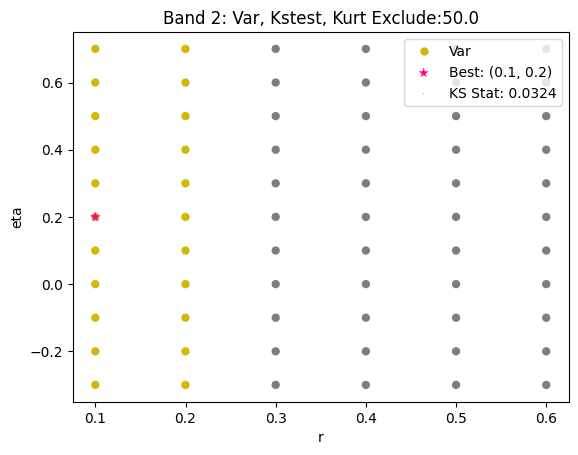

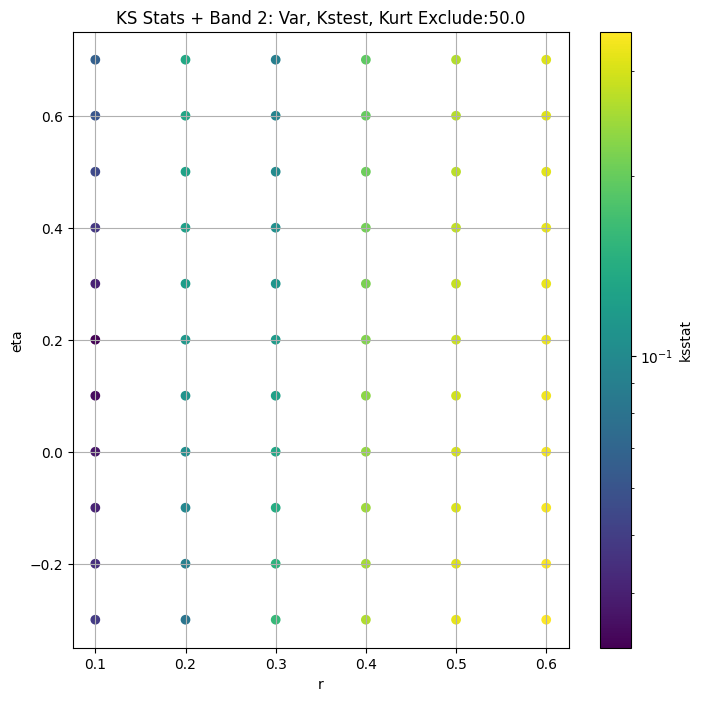

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.027218956380976822 2880509200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.027129722002658563 2844121000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.02689847567935373 2813727500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.027612364451053972 2786255400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.028278972736292263 2760732200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.027747223760456408 2713779500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.028871725599668233 2670843400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0286950240115319 2630926300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.029371741510329646 2593444600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.029597362067747213 2557988600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.030352787122007868 2461038000.0
Number of samples: 100000, Without approximation : 57824238.0


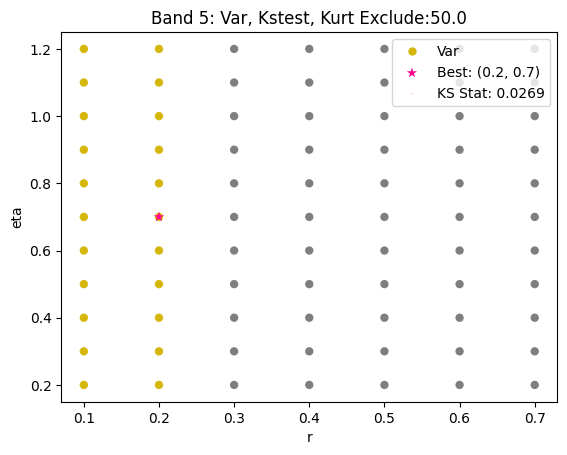

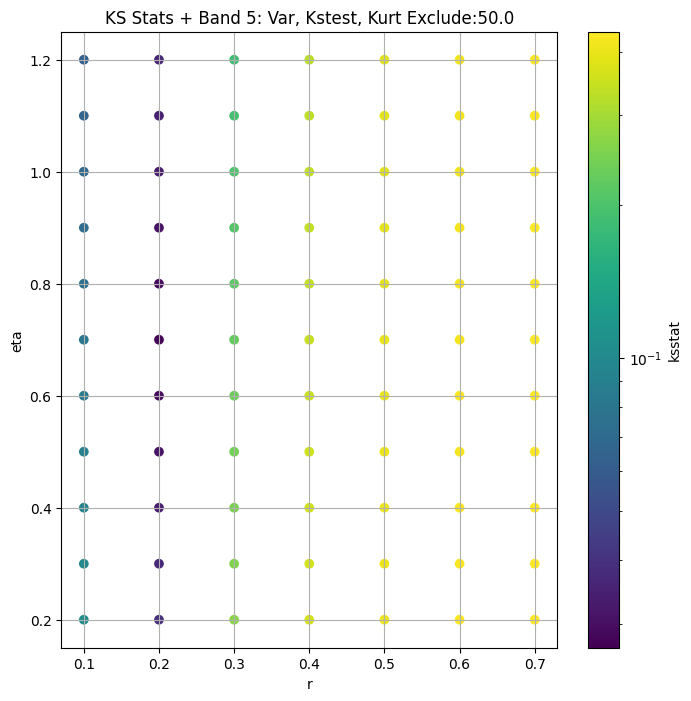

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.019616589761357384 1827356300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.020651359660319807 1802211500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.02080708549712529 1780453400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.020559699772213738 1760713100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0213472267922082 1742526700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.021348243864322214 1709589000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.022444752061535844 1679980800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.022174679555985843 1652821100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.023177991714608215 1627573200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.023072214414996614 1603862000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02432353006037591 1539612500.0
Number of samples: 100000, Without approximation : 57824238.0


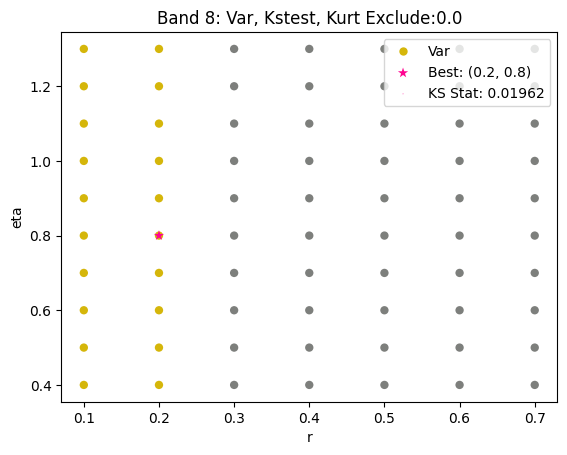

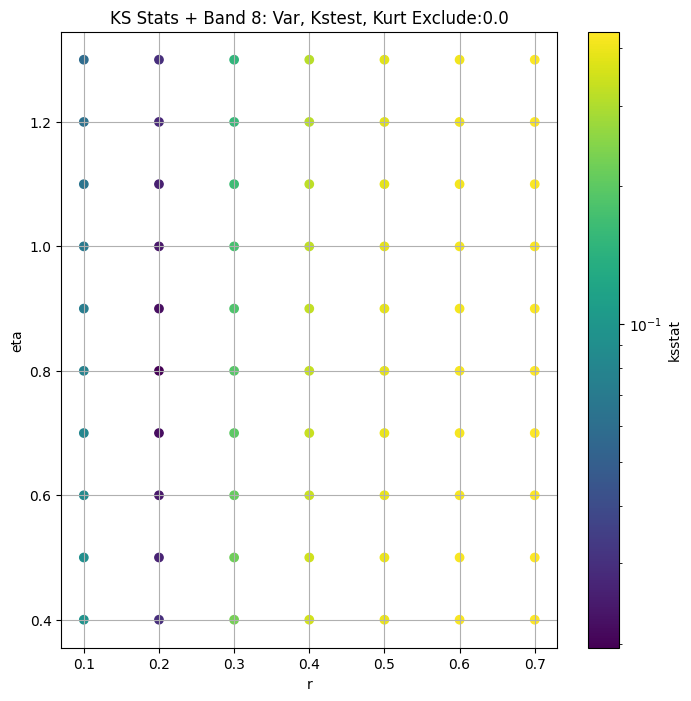

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.029669048915603513 1390923600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.03028159478803294 1376875000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030164221205859043 1364519800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.02980600380424203 1353003400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.02957883570240065 1342072300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.030503645963619486 1321519900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.031385386912060956 1302300300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.03179471050996807 1284120000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.031216696514108855 1266798600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.03189149841910549 1250205200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.032872778472930686 1203955000.0
Number of samples: 100000, Without approximation : 57824238.0


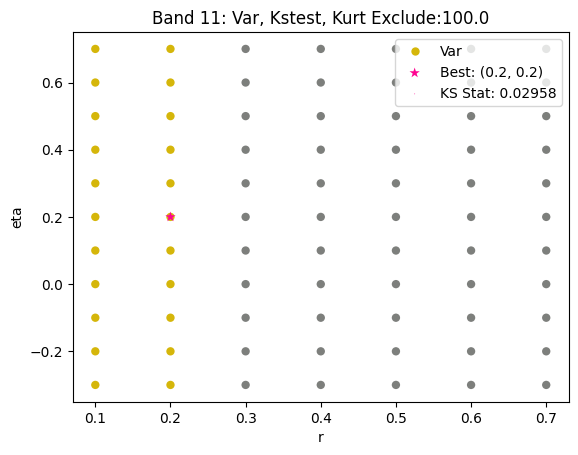

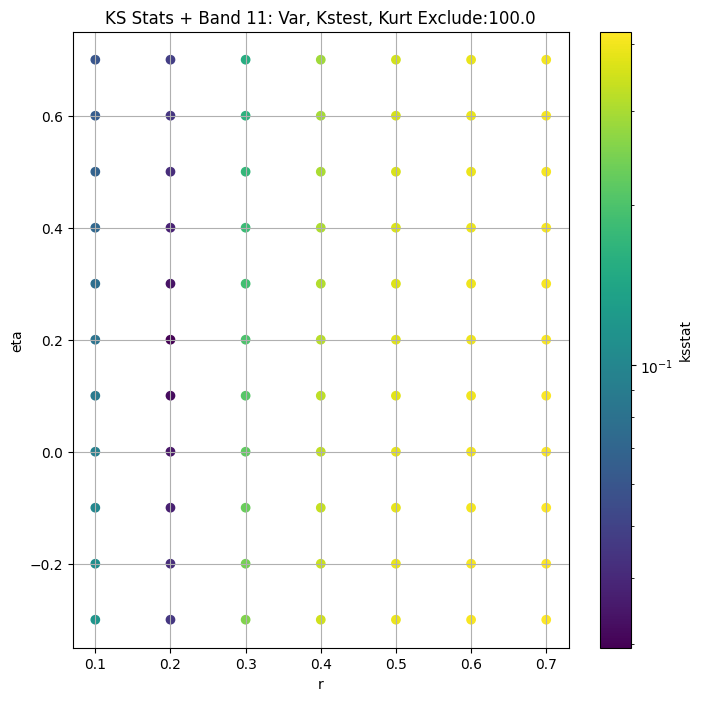

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019282082585958538 292119680.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.018255622217168976 284536160.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.01791484431705055 278533660.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.018965760996406344 273232300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.019940587564115375 268397120.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.021745896385216984 259711000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.021657588839620545 251973740.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.020951680015714014 244942940.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02241054453483804 238472850.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.023804886995010058 232461680.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.024377088466147057 216551580.0
Number of samples: 100000, Without approximation : 57824238.0


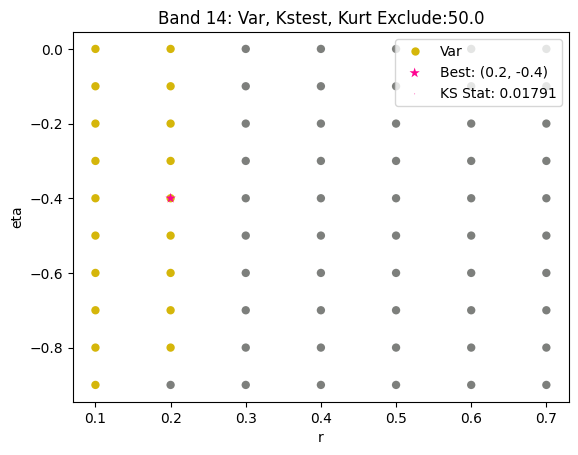

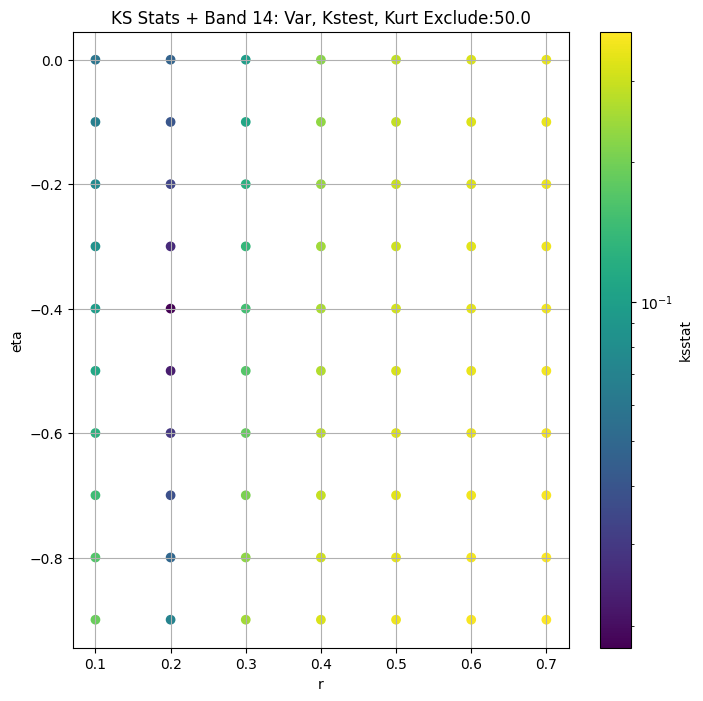

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.014994905145970822 54150656.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.016634630439401388 52338788.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.015943350659490263 51169776.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.016742832362327376 50199990.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.017680250008296358 49352390.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.017992300650285453 47893716.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.01872042923081685 46645412.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.020030517128806394 45542732.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.019478913935975103 44548050.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.020605381422702115 43637184.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.022128845521807494 41264096.0
Number of samples: 100000, Without approximation : 57824238.0


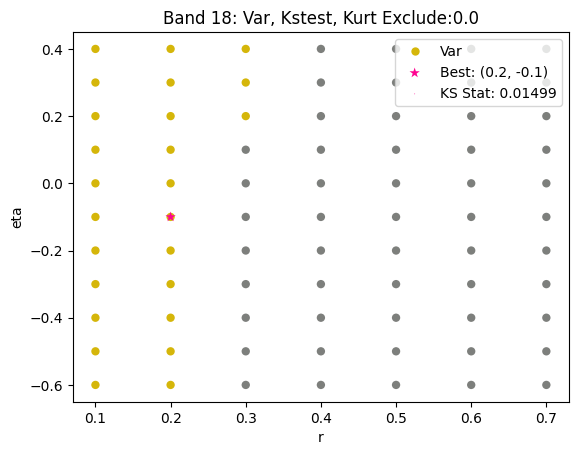

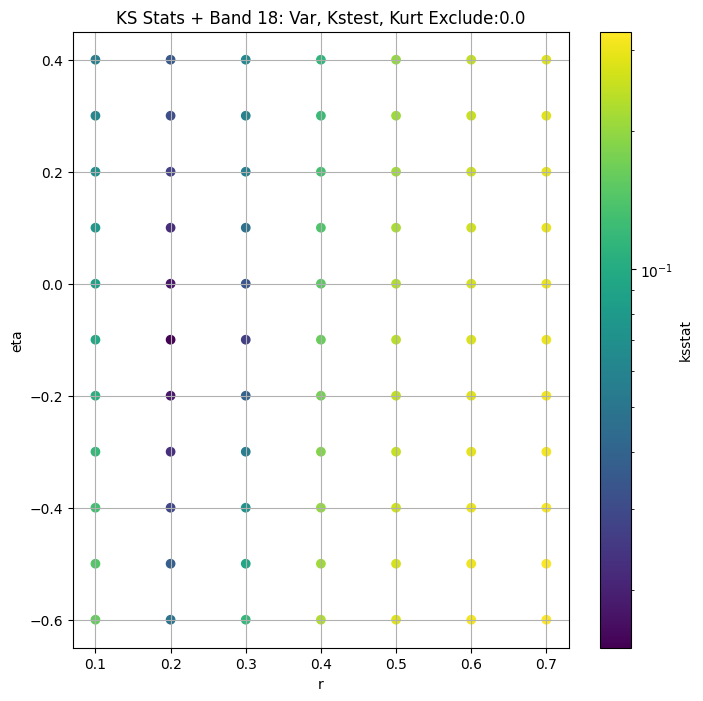

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.01116101492484367 23956060.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.012373622616767208 22716258.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.01410966217388887 21948830.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.015599177096196015 21330052.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.015100040640016021 20801738.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.015043455742336079 19919444.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.01684862538629084 19190692.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.018503805573099233 18565284.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.01763713559237634 18013468.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.01826731830364403 17515718.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02067410286315924 16246266.0
Number of samples: 100000, Without approximation : 57824238.0


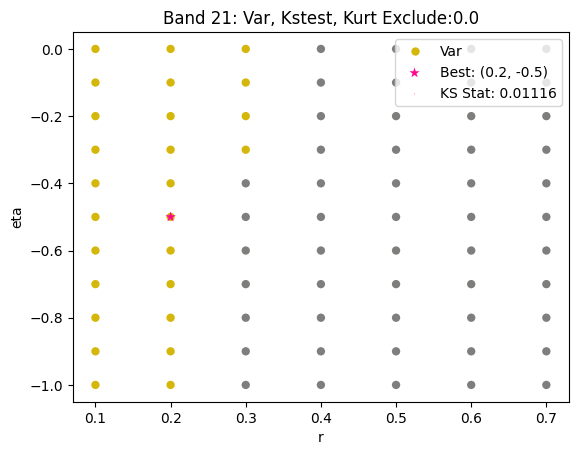

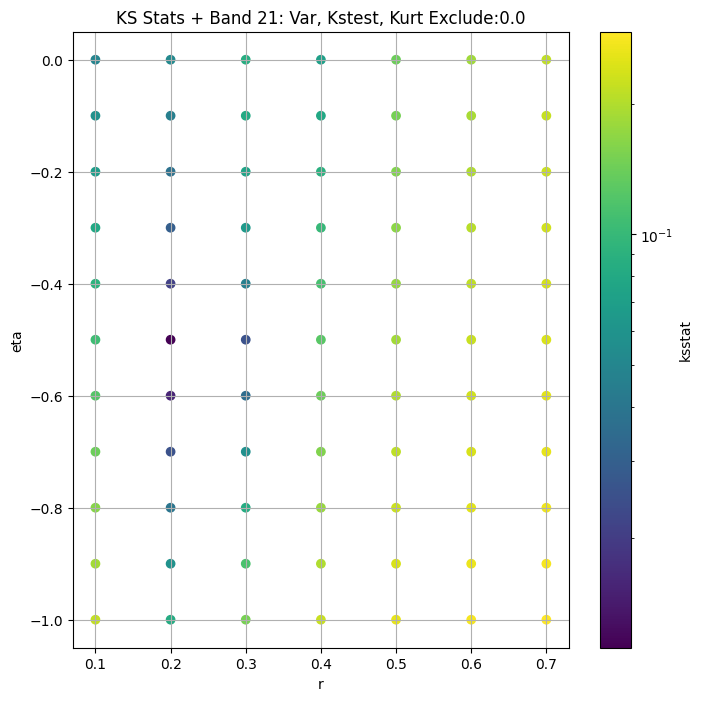

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.00966087587230411 18260452.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009798872476268428 17169760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.00966073437669035 16359667.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.010583876182334195 15672725.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.011463255355214308 15067948.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.013156845770555259 14030691.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.01477932336504123 13155991.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.016367846240714523 12398347.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.015551086785637103 11730008.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.012915615976889727 11132799.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.015053864357288317 9658326.0
Number of samples: 100000, Without approximation : 57824238.0


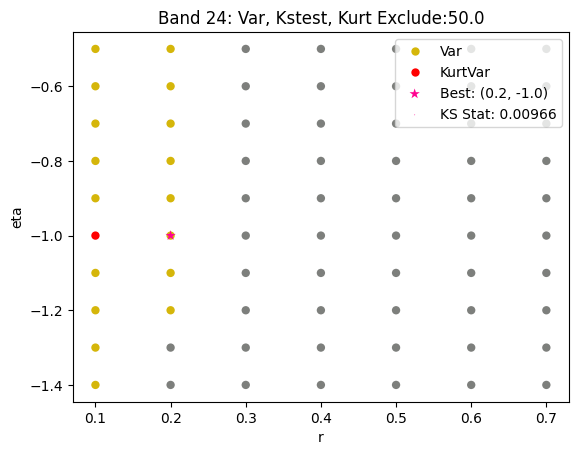

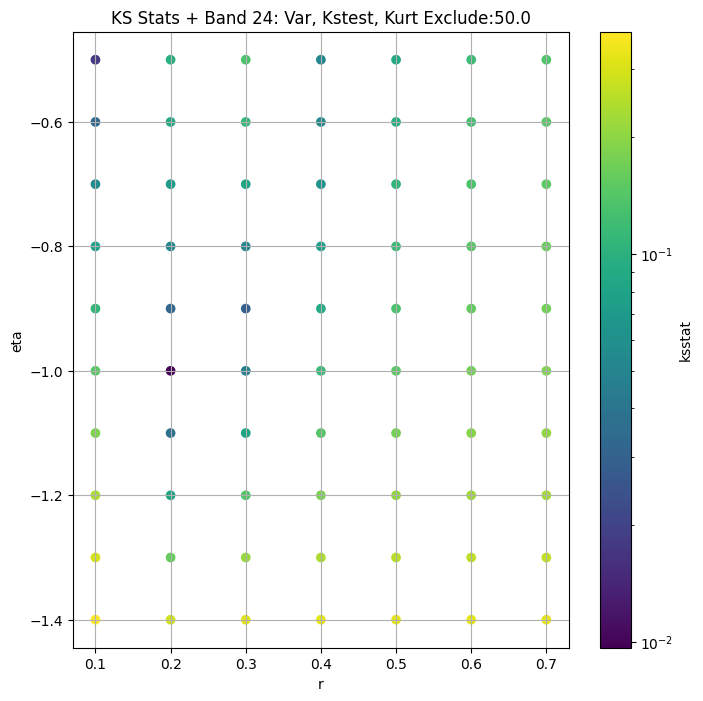

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.016132377537645848 8273984.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.015928023115634016 7668714.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.01541757138580313 7220857.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.014810846153464174 6844647.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.015524914740971285 6516590.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.015326673997296925 5960229.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.015758359127660992 5497548.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.016851899828445593 5101794.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.016634524747189627 4757081.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.016362185676613406 4452586.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.01416871550140758 3714665.2
Number of samples: 100000, Without approximation : 57824238.0


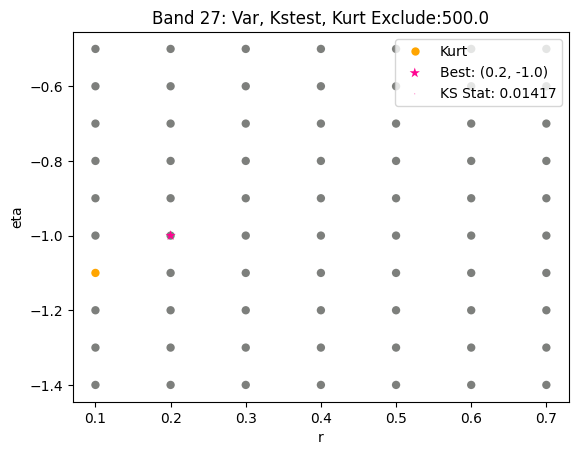

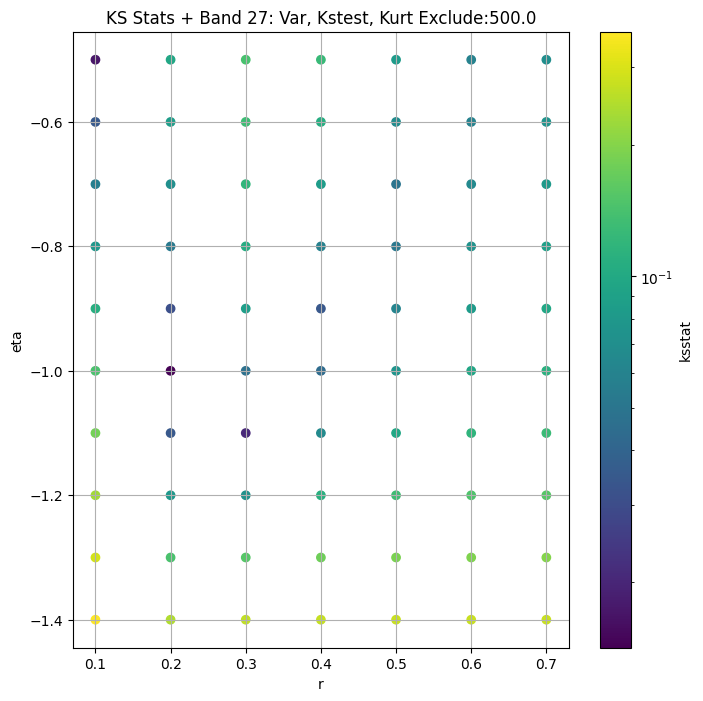

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.03855228352117368 240011.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03835690577752915 211645.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.038233929275926504 195275.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.038137379308277874 182150.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03804932777803971 171086.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03789818191897404 153130.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03776842464169272 138904.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03813498943506166 127189.51


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.038023937506908245 117295.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03792371888429247 108786.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.037668473862047414 88968.97
Number of samples: 100000, Without approximation : 57824238.0


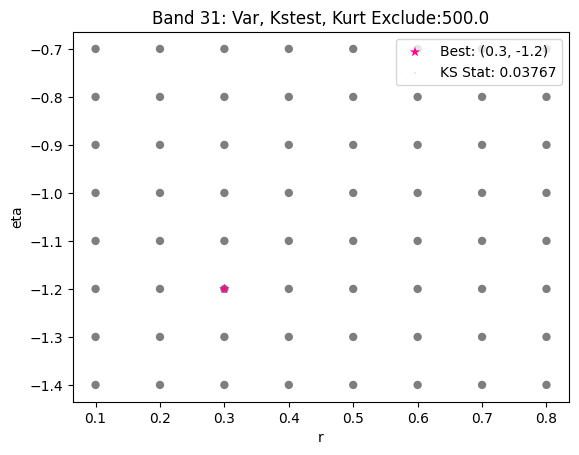

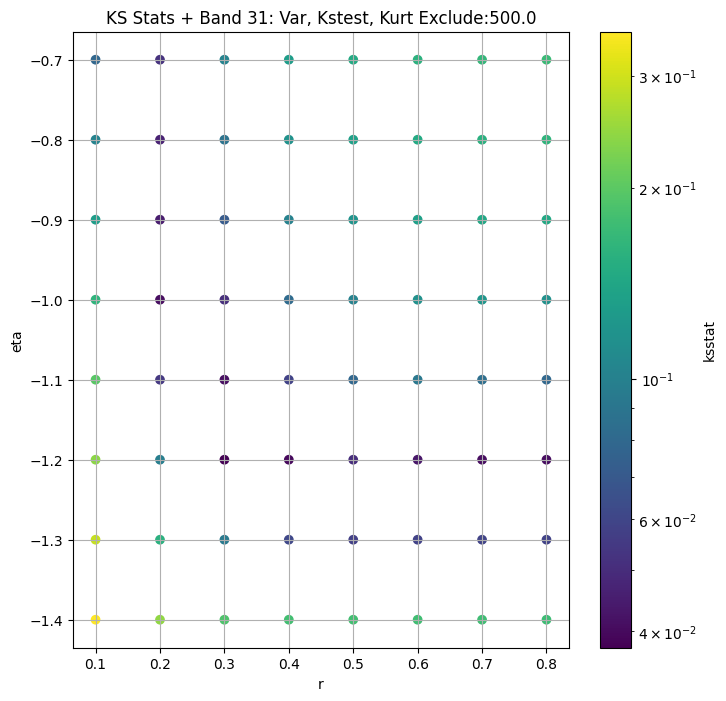

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     1.177774e+09  1.085649e+09  1.276239e+09   7.888103    6.781435   
5     2.880509e+09  2.718593e+09  3.046499e+09   2.915701    2.525911   
8     1.827356e+09  1.720742e+09  1.937364e+09   3.388295    2.926564   
11    1.390924e+09  1.312385e+09  1.470517e+09   2.917553    2.612940   
14    2.921197e+08  2.674729e+08  3.178738e+08   9.318104    8.035010   
18    5.415066e+07  4.980312e+07  5.888757e+07   8.531016    6.306366   
21    2.395606e+07  2.142995e+07  2.678720e+07  16.482788   11.398751   
24    1.826045e+07  1.571240e+07  2.106897e+07  30.356003   24.832960   
27    8.273984e+06  6.927880e+06  9.753366e+06  42.051674   34.199646   
31    2.400116e+05  1.916386e+05  3.022838e+05  75.993420   46.090584   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.279733     57824238.0             0.032395        0.1          0.2   
5       3.333546     57824238.0             0.026898        0.2          0.7   
8       3.872236     57824238.0             0.019617        0.2          0.8   
11      3.238348     57824238.0             0.029579        0.2          0.2   
14     10.718221     57824238.0             0.017915        0.2         -0.4   
18     12.651335     57824238.0             0.014995        0.2         -0.1   
21     25.385132     57824238.0             0.011161        0.2         -0.5   
24     36.771297     57824238.0             0.009661        0.2         -1.0   
27     51.289660     57824238.0             0.014169        0.2         -1.0   
31    178.931350     57824238.0             0.037668        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000059                    50.0        1.129415e+09   
5       7808.101587                    50.0        2.813728e+09   
8       4189.690188                     0.0        1.827356e+09   
11     11011.240182                   100.0        1.342072e+09   
14     12864.646341                    50.0        2.785337e+08   
18       976.743434                     0.0        5.415066e+07   
21      1584.395503                     0.0        2.395606e+07   
24     11621.919059                    50.0        1.635967e+07   
27      2638.900833                   500.0        3.714665e+06   
31      9607.331912                   500.0        8.896897e+04   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000179  
5                    0.000179  
8                    0.000179  
11                   0.000179  
14                   0.000179  
18                   0.000179  
21                   0.000179  
24                   0.000179  
27                   0.000179  
31                   0.000179

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.032055471086152476, var: 1065668416.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.03235363427550864, var: 1080015360.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.031836382340760694, var: 1095232640.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.032339935212984394, var: 1111565440.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.03236780367451897, var: 1129414784.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.03171104371641564, var: 1149718144.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.031579670828362216, var: 1177774336.0
Number of samples: 100000, Without approximation : 57824238.0


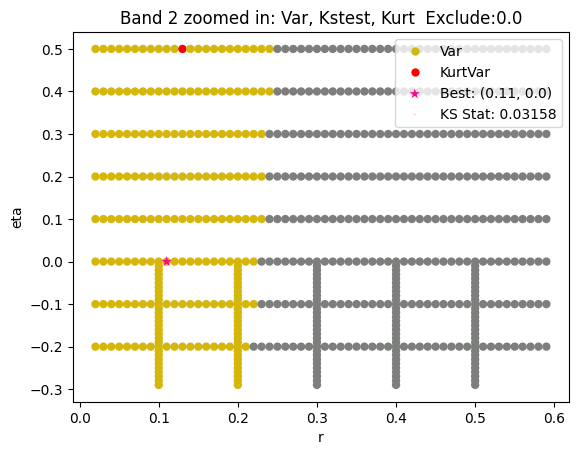

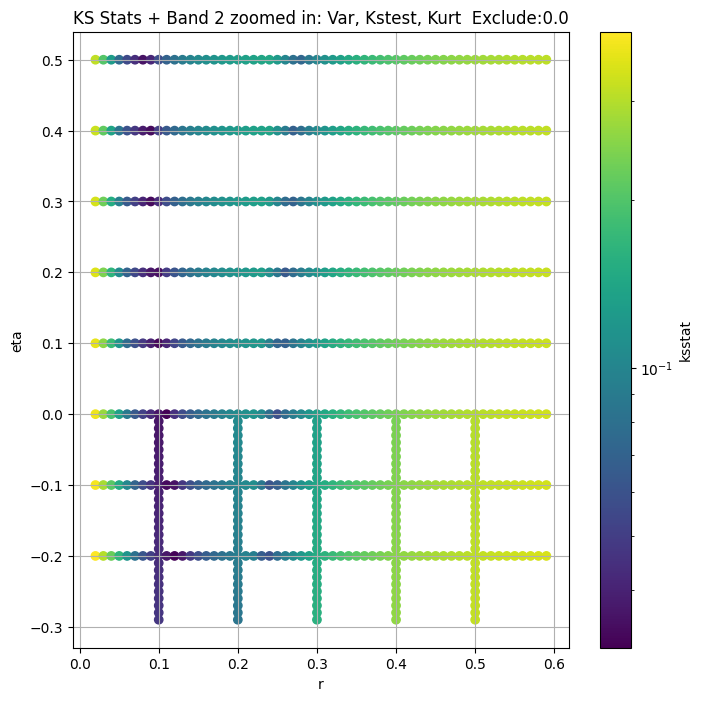

Band 5


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + 100 = 150, ksstat: 0.027747223760456408, var: 2713779456.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + 75 = 125, ksstat: 0.02778902780245436, var: 2736663040.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + 50 = 100, ksstat: 0.027600436147668314, var: 2760732160.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + 25 = 75, ksstat: 0.026930827740918845, var: 2786255360.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + 0 = 50, ksstat: 0.026680361867576274, var: 2813727488.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + -25 = 25, ksstat: 0.026850803483569385, var: 2844121088.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 5, 50.0 + -50 = 0, ksstat: 0.026698351293871395, var: 2880509184.0
Number of samples: 100000, Without approximation : 57824238.0


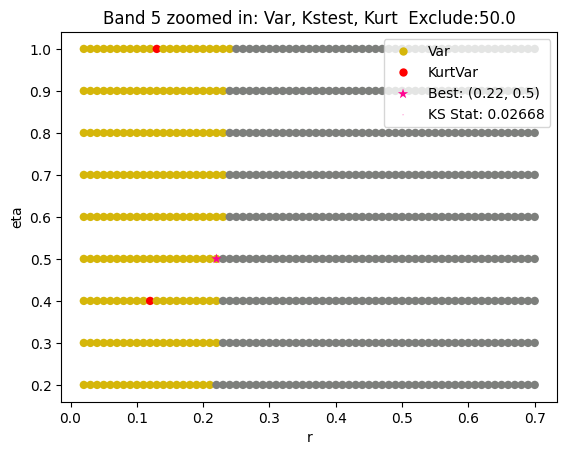

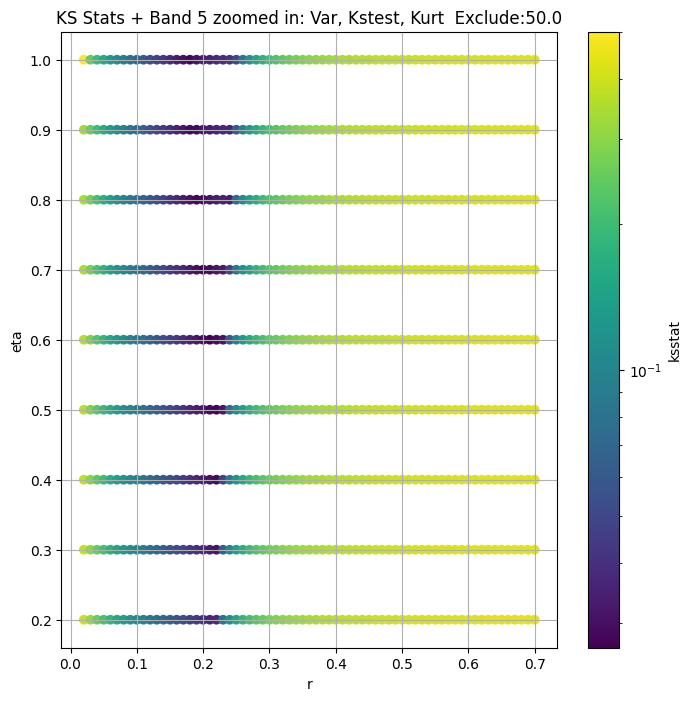

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.020209040332050954, var: 1742526720.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.020559699772213738, var: 1760713088.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.020494661301241113, var: 1780453376.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.01967174239050498, var: 1802211456.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.01944661152361704, var: 1827356288.0
Number of samples: 100000, Without approximation : 57824238.0


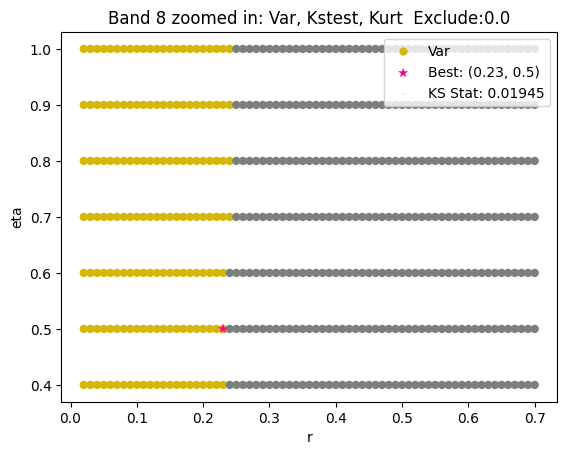

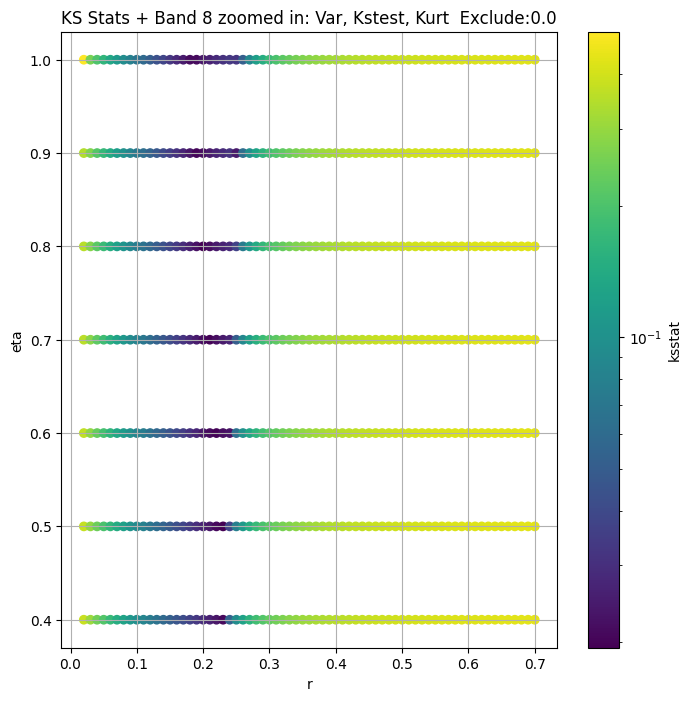

Band 11


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + 100 = 200, ksstat: 0.030694915058227634, var: 1302300288.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + 75 = 175, ksstat: 0.030948089313436428, var: 1311765760.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + 50 = 150, ksstat: 0.030503645963619486, var: 1321519872.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + 25 = 125, ksstat: 0.030048059622970205, var: 1331603456.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + 0 = 100, ksstat: 0.02957883570240065, var: 1342072320.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + -25 = 75, ksstat: 0.02909967752848197, var: 1353003392.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + -50 = 50, ksstat: 0.028823442938000765, var: 1364519808.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + -75 = 25, ksstat: 0.028283361003377916, var: 1376875008.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 100.0 + -100 = 0, ksstat: 0.028647331166881784, var: 1390923648.0
Number of samples: 100000, Without approximation : 57824238.0


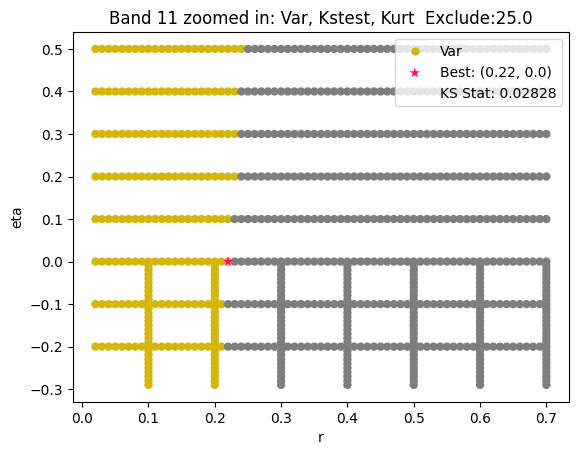

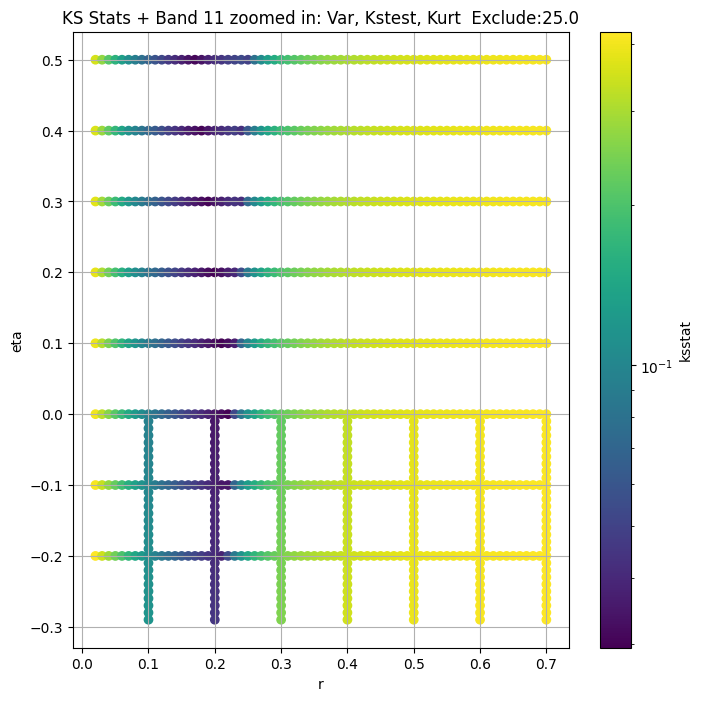

Band 14


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + 100 = 150, ksstat: 0.01929264053644264, var: 259711008.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + 75 = 125, ksstat: 0.019172611142173612, var: 263913632.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + 50 = 100, ksstat: 0.01861879551851396, var: 268397120.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + 25 = 75, ksstat: 0.017643361581944905, var: 273232288.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + 0 = 50, ksstat: 0.017338395217740943, var: 278533664.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + -25 = 25, ksstat: 0.017388483665202736, var: 284536160.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 50.0 + -50 = 0, ksstat: 0.01667197286029276, var: 292119680.0
Number of samples: 100000, Without approximation : 57824238.0


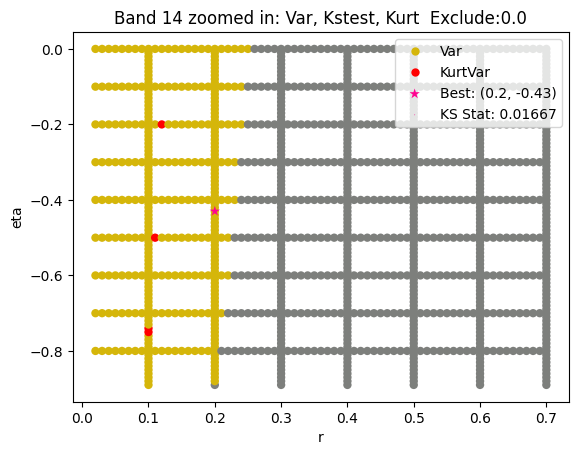

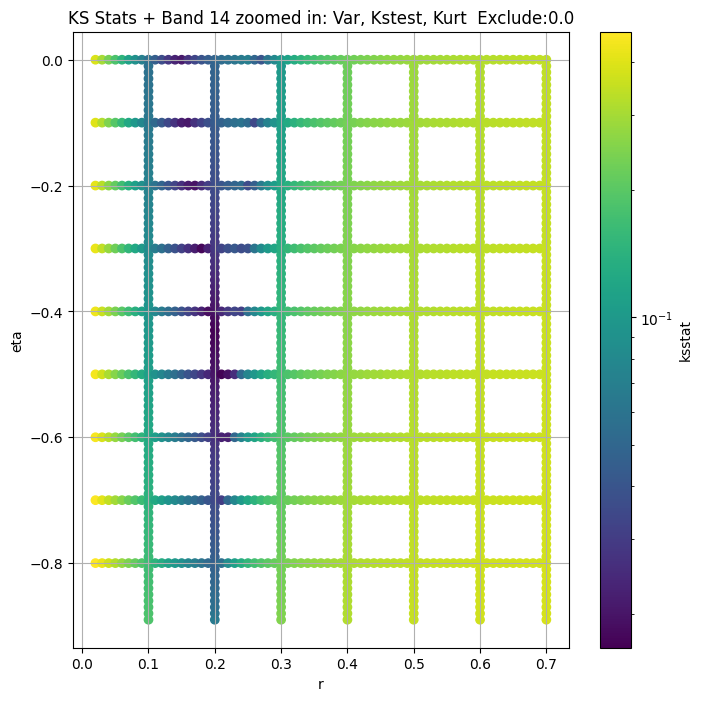

Band 18


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.015633450786653513, var: 49352392.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01474802149771852, var: 50199992.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.01479448088550811, var: 51169776.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.013563209991225456, var: 52338788.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.013362801092509216, var: 54150656.0
Number of samples: 100000, Without approximation : 57824238.0


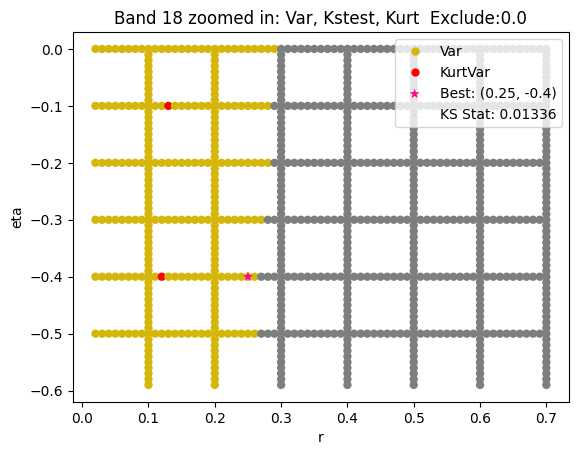

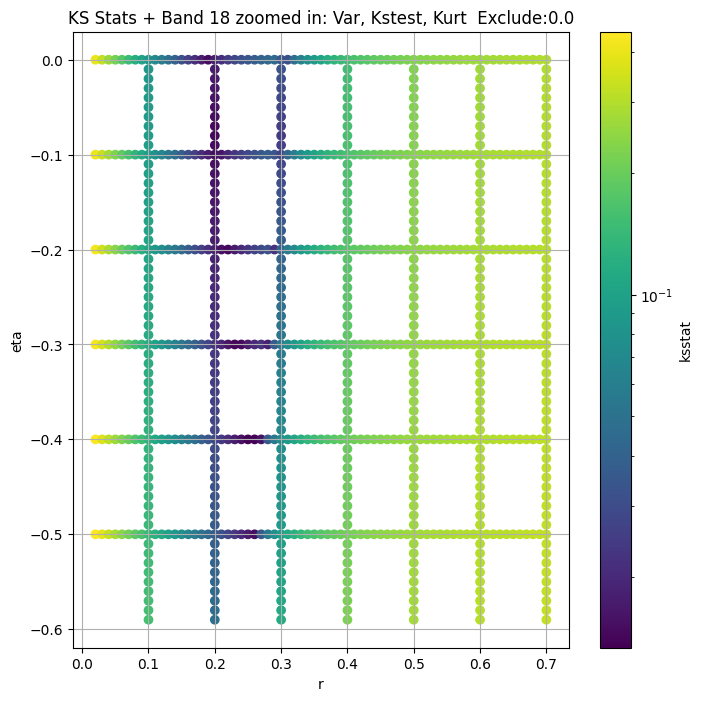

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.011743679053044229, var: 20801738.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.01059756490203162, var: 21330052.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.011017053204026017, var: 21948830.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.0094067694509829, var: 22716258.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.008894604654946403, var: 23956060.0
Number of samples: 100000, Without approximation : 57824238.0


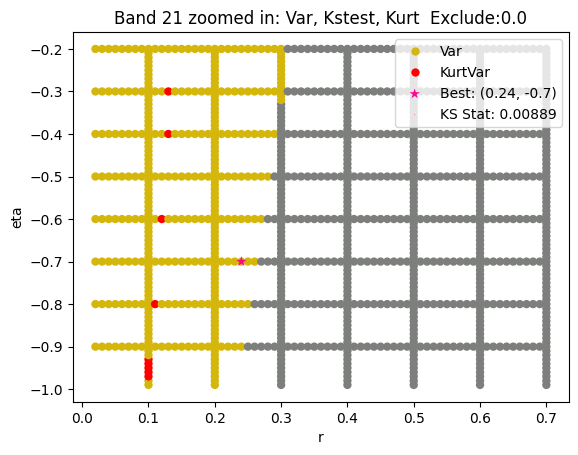

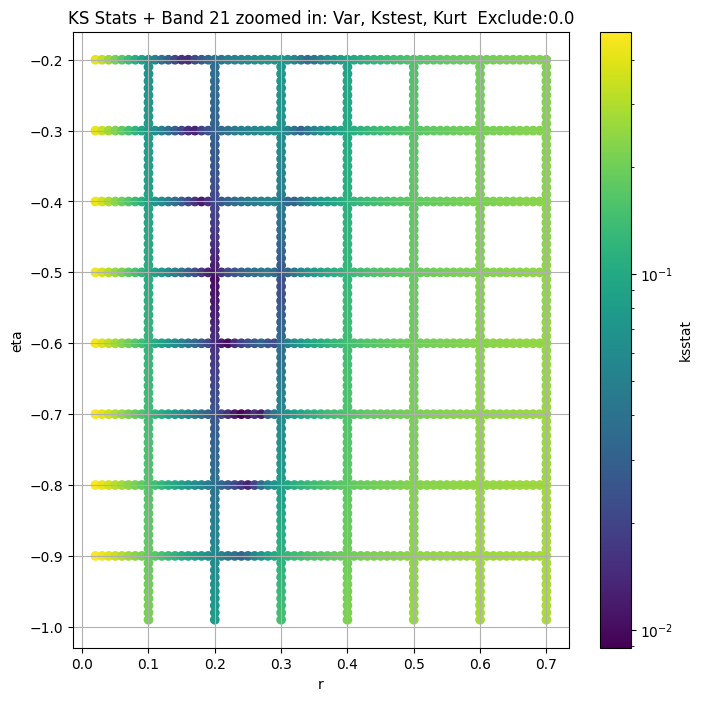

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + 100 = 150, ksstat: 0.008325668755887194, var: 14030691.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + 75 = 125, ksstat: 0.008206508914796965, var: 14525131.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + 50 = 100, ksstat: 0.008413432928352282, var: 15067948.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + 25 = 75, ksstat: 0.008502320207311953, var: 15672725.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + 0 = 50, ksstat: 0.0077661693556248385, var: 16359667.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + -25 = 25, ksstat: 0.007903157767300772, var: 17169760.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 50.0 + -50 = 0, ksstat: 0.008086332118909502, var: 18260452.0
Number of samples: 100000, Without approximation : 57824238.0


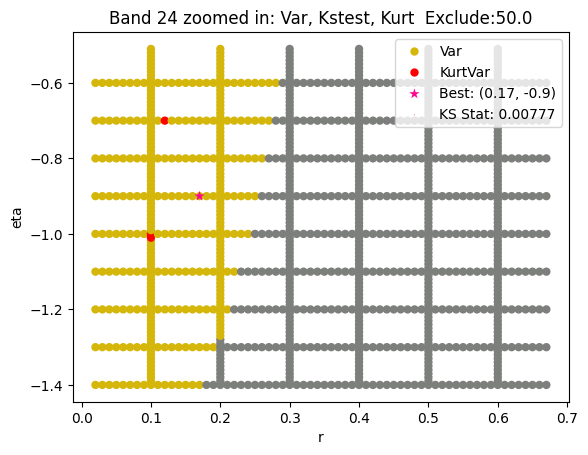

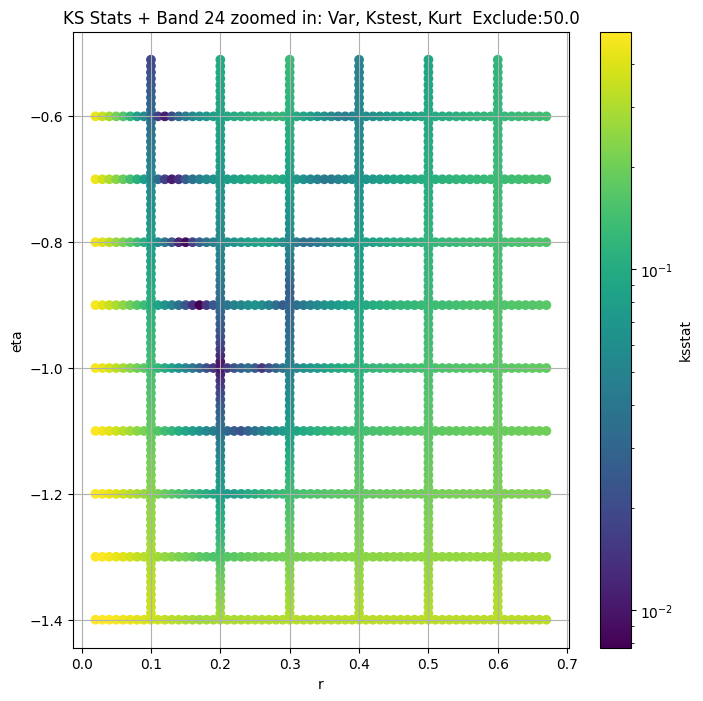

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + 100 = 600, ksstat: 0.012554514248732218, var: 3327881.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + 75 = 575, ksstat: 0.012277435639524437, var: 3418269.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + 50 = 550, ksstat: 0.01231811212769196, var: 3512682.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + 25 = 525, ksstat: 0.012359333446477327, var: 3611374.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + 0 = 500, ksstat: 0.012401600634066812, var: 3714665.25


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + -25 = 475, ksstat: 0.012444273683379303, var: 3822852.25


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + -50 = 450, ksstat: 0.01248744138568092, var: 3936323.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + -75 = 425, ksstat: 0.012186908646813321, var: 4055516.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 500.0 + -100 = 400, ksstat: 0.012232329240732476, var: 4180899.5
Number of samples: 100000, Without approximation : 57824238.0


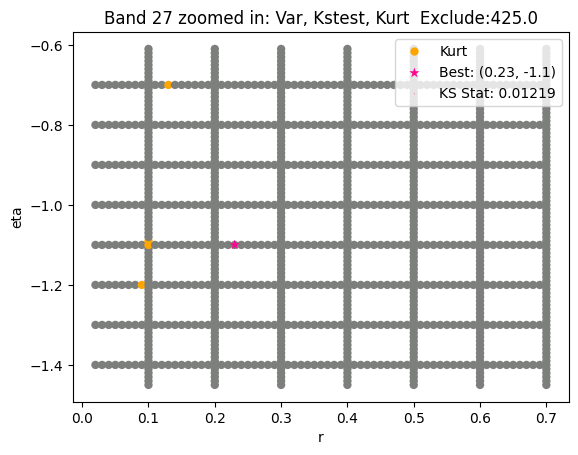

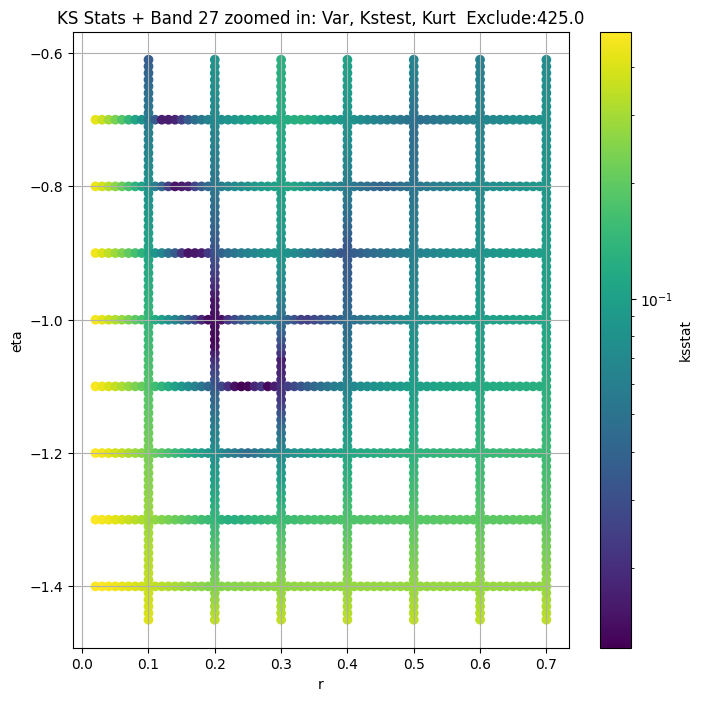

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 100 = 600, ksstat: 0.03386918273855033, var: 79009.8125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 75 = 575, ksstat: 0.03386918273855033, var: 81312.890625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 50 = 550, ksstat: 0.03386918273855033, var: 83734.3046875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 25 = 525, ksstat: 0.03386918273855033, var: 86282.34375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 0 = 500, ksstat: 0.03386918273855033, var: 88968.96875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -25 = 475, ksstat: 0.03386918273855033, var: 91805.046875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -50 = 450, ksstat: 0.03386918273855033, var: 94804.609375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -75 = 425, ksstat: 0.03386918273855033, var: 97982.453125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -100 = 400, ksstat: 0.03386918273855033, var: 101358.0
Number of samples: 100000, Without approximation : 57824238.0


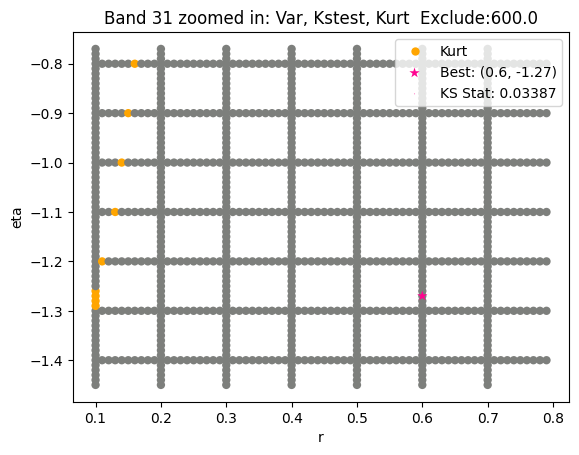

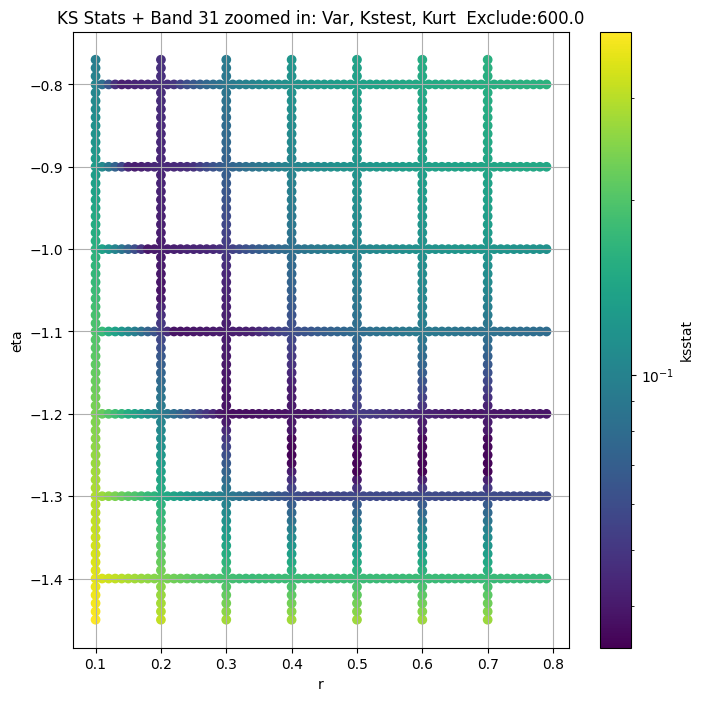

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     1.177774e+09  1.085649e+09  1.276239e+09   7.888103    6.781435   
5     2.880509e+09  2.718593e+09  3.046499e+09   2.915701    2.525911   
8     1.827356e+09  1.720742e+09  1.937364e+09   3.388295    2.926564   
11    1.390924e+09  1.312385e+09  1.470517e+09   2.917553    2.612940   
14    2.921197e+08  2.674729e+08  3.178738e+08   9.318104    8.035010   
18    5.415066e+07  4.980312e+07  5.888757e+07   8.531016    6.306366   
21    2.395606e+07  2.142995e+07  2.678720e+07  16.482788   11.398751   
24    1.826045e+07  1.571240e+07  2.106897e+07  30.356003   24.832960   
27    8.273984e+06  6.927880e+06  9.753366e+06  42.051674   34.199646   
31    2.400116e+05  1.916386e+05  3.022838e+05  75.993420   46.090584   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.279733     57824238.0             0.032395        0.1          0.2   
5       3.333546     57824238.0             0.026898        0.2          0.7   
8       3.872236     57824238.0             0.019617        0.2          0.8   
11      3.238348     57824238.0             0.029579        0.2          0.2   
14     10.718221     57824238.0             0.017915        0.2         -0.4   
18     12.651335     57824238.0             0.014995        0.2         -0.1   
21     25.385132     57824238.0             0.011161        0.2         -0.5   
24     36.771297     57824238.0             0.009661        0.2         -1.0   
27     51.289660     57824238.0             0.014169        0.2         -1.0   
31    178.931350     57824238.0             0.037668        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000059                    50.0        1.177774e+09   
5       7808.101587                    50.0        2.813727e+09   
8       4189.690188                     0.0        1.827356e+09   
11     11011.240182                   100.0        1.376875e+09   
14     12864.646341                    50.0        2.921197e+08   
18       976.743434                     0.0        5.415066e+07   
21      1584.395503                     0.0        2.395606e+07   
24     11621.919059                    50.0        1.635967e+07   
27      2638.900833                   500.0        4.055516e+06   
31      9607.331912                   500.0        7.900981e+04   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000179          0.031580    0.11      0.00   
5                    0.000179          0.026680    0.22      0.50   
8                    0.000179          0.019447    0.23      0.50   
11                   0.000179          0.028283    0.22      0.00   
14                   0.000179          0.016672    0.20     -0.43   
18                   0.000179          0.013363    0.25     -0.40   
21                   0.000179          0.008895    0.24     -0.70   
24                   0.000179          0.007766    0.17     -0.90   
27                   0.000179          0.012187    0.23     -1.10   
31                   0.000179          0.033869    0.60     -1.27   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2          0.005939                  0.0         1764  
5      56776.544501                 50.0         2646  
8      72231.534489                  0.0         5022  
11     82336.770130                 25.0         2232  
14     14984.694164                  0.0         6696  
18     48122.213122                  0.0        10587  
21     35566.374405                  0.0        23821  
24       571.373139                

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

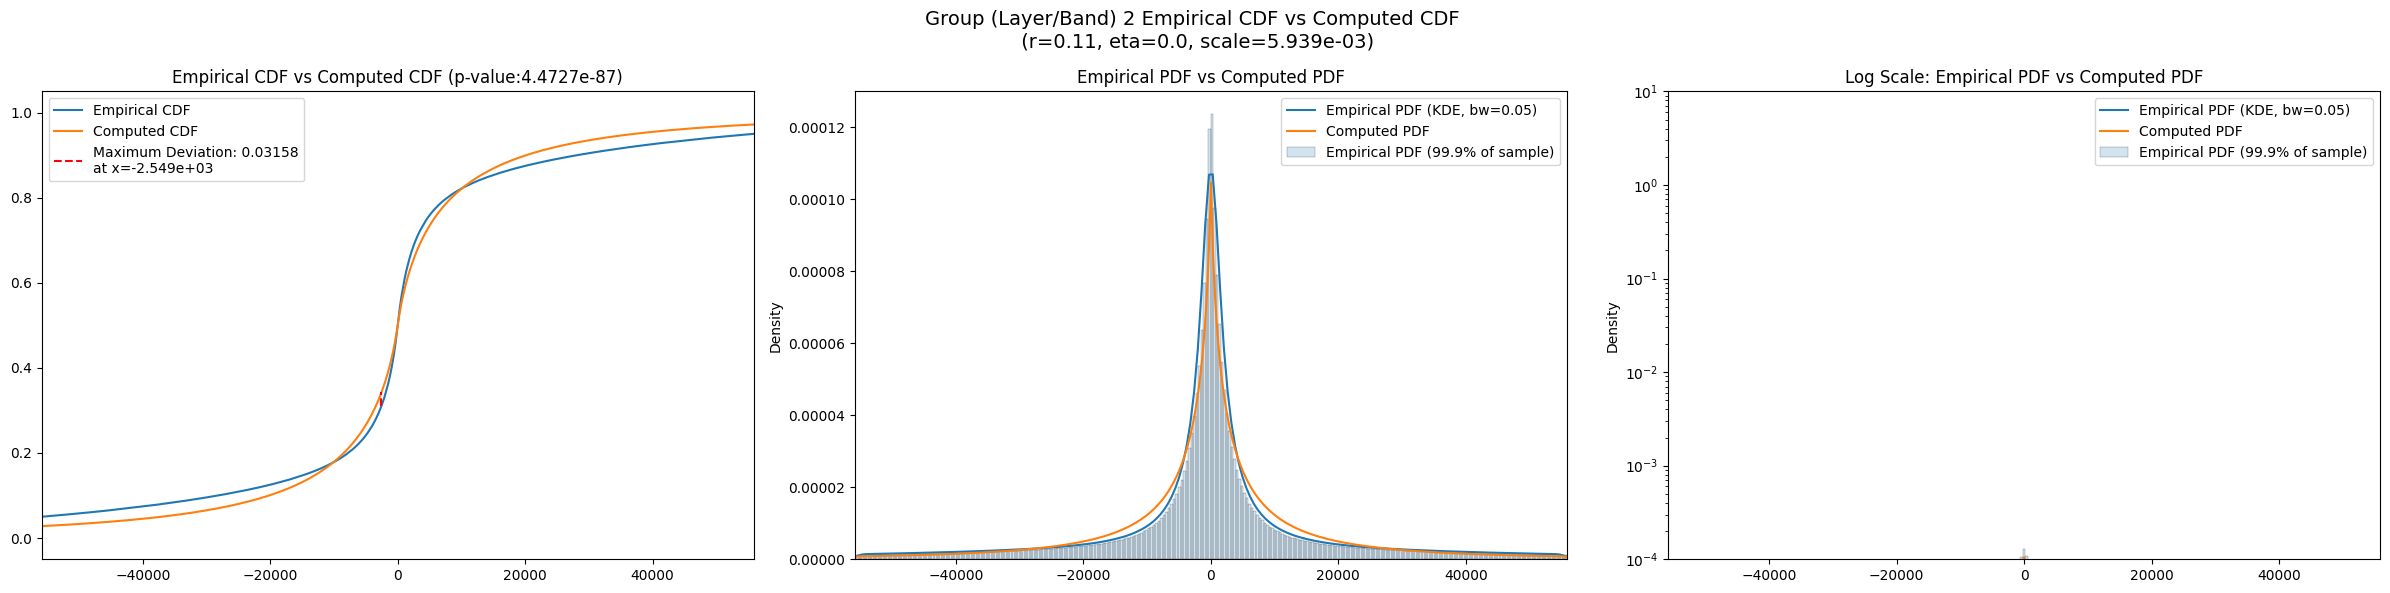

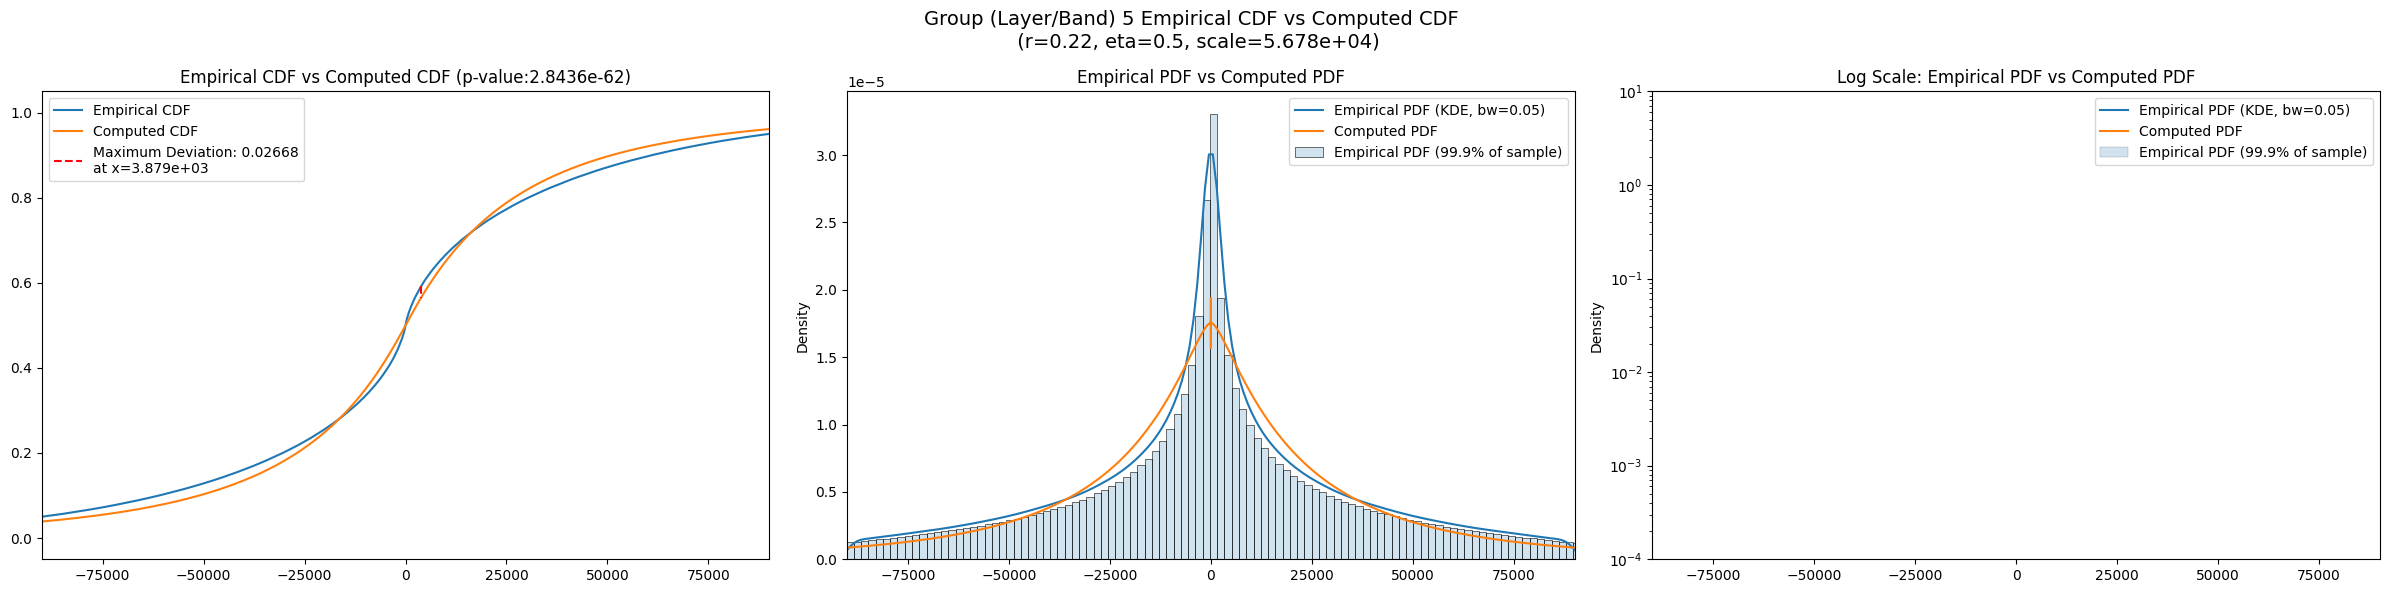

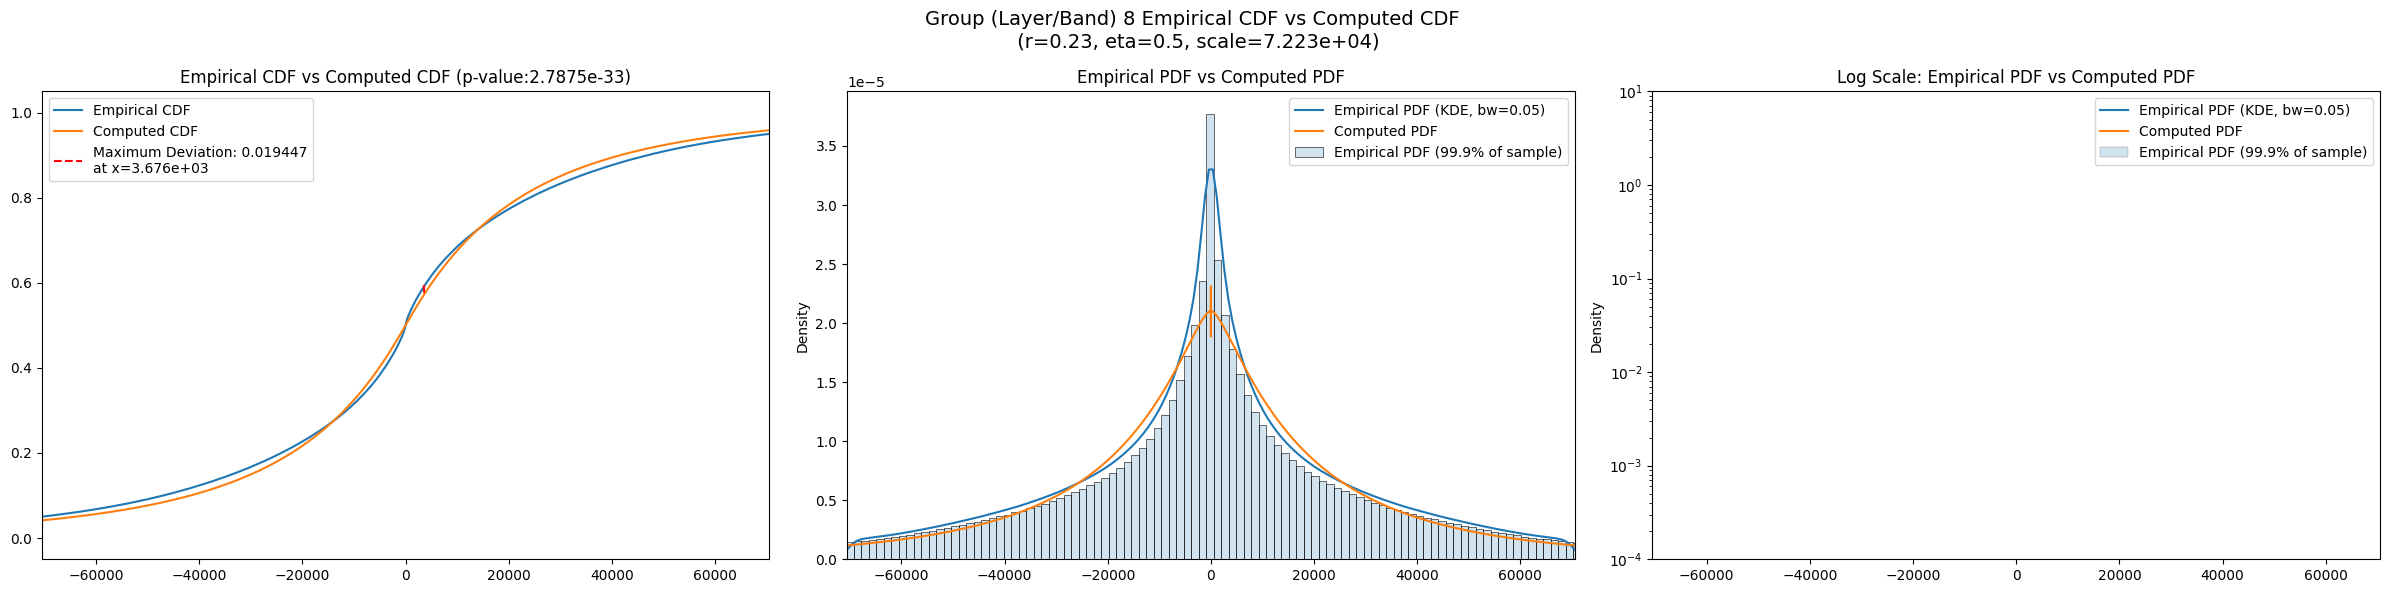

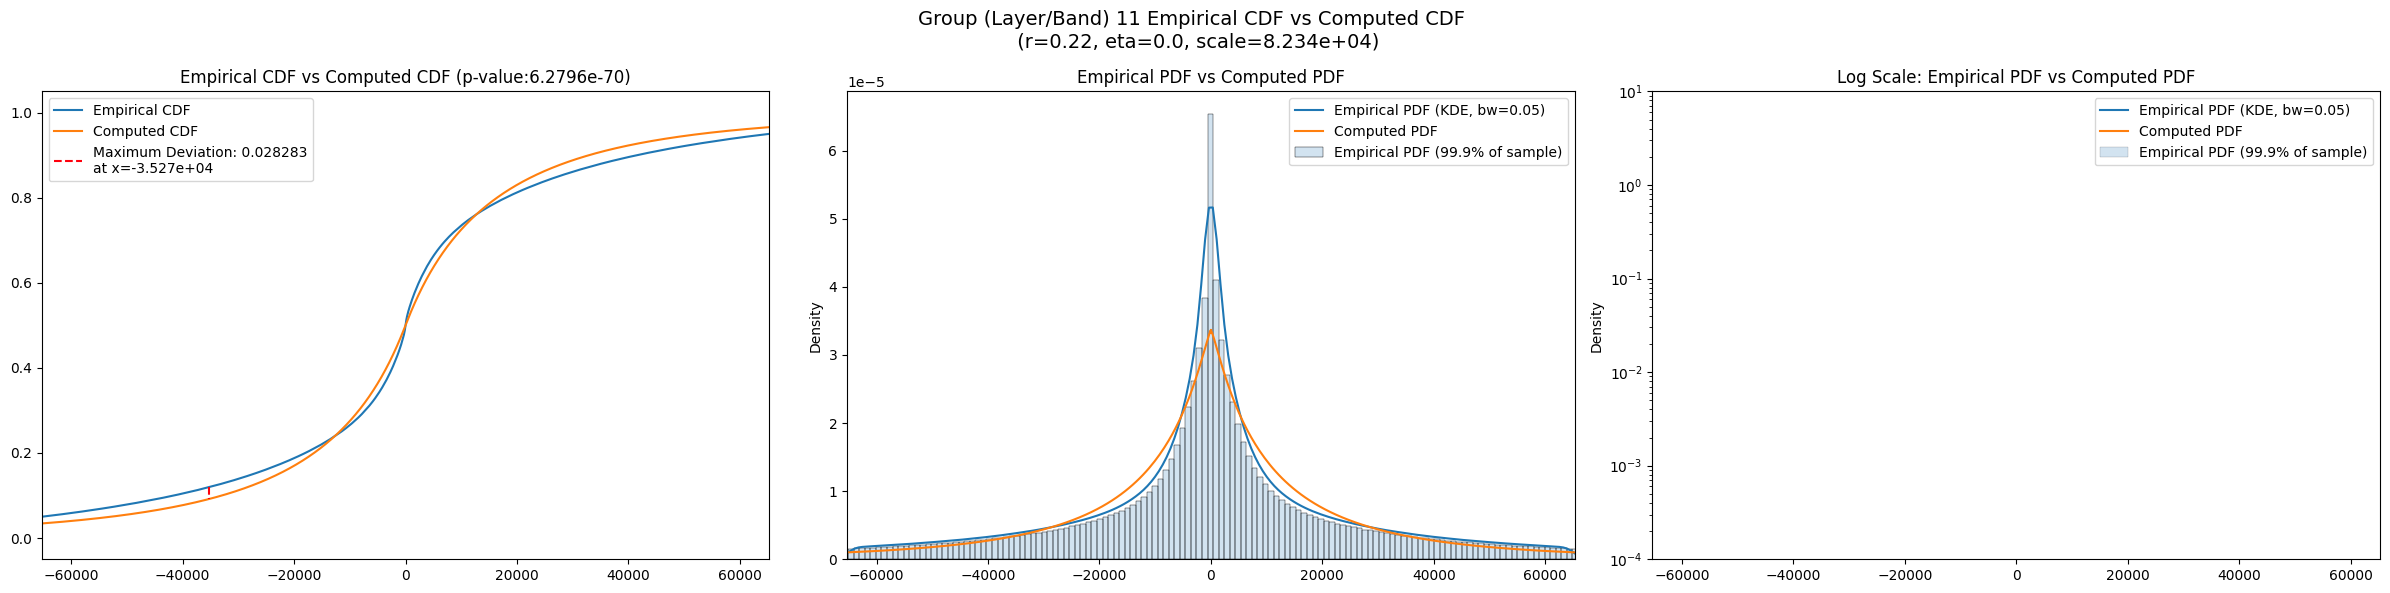

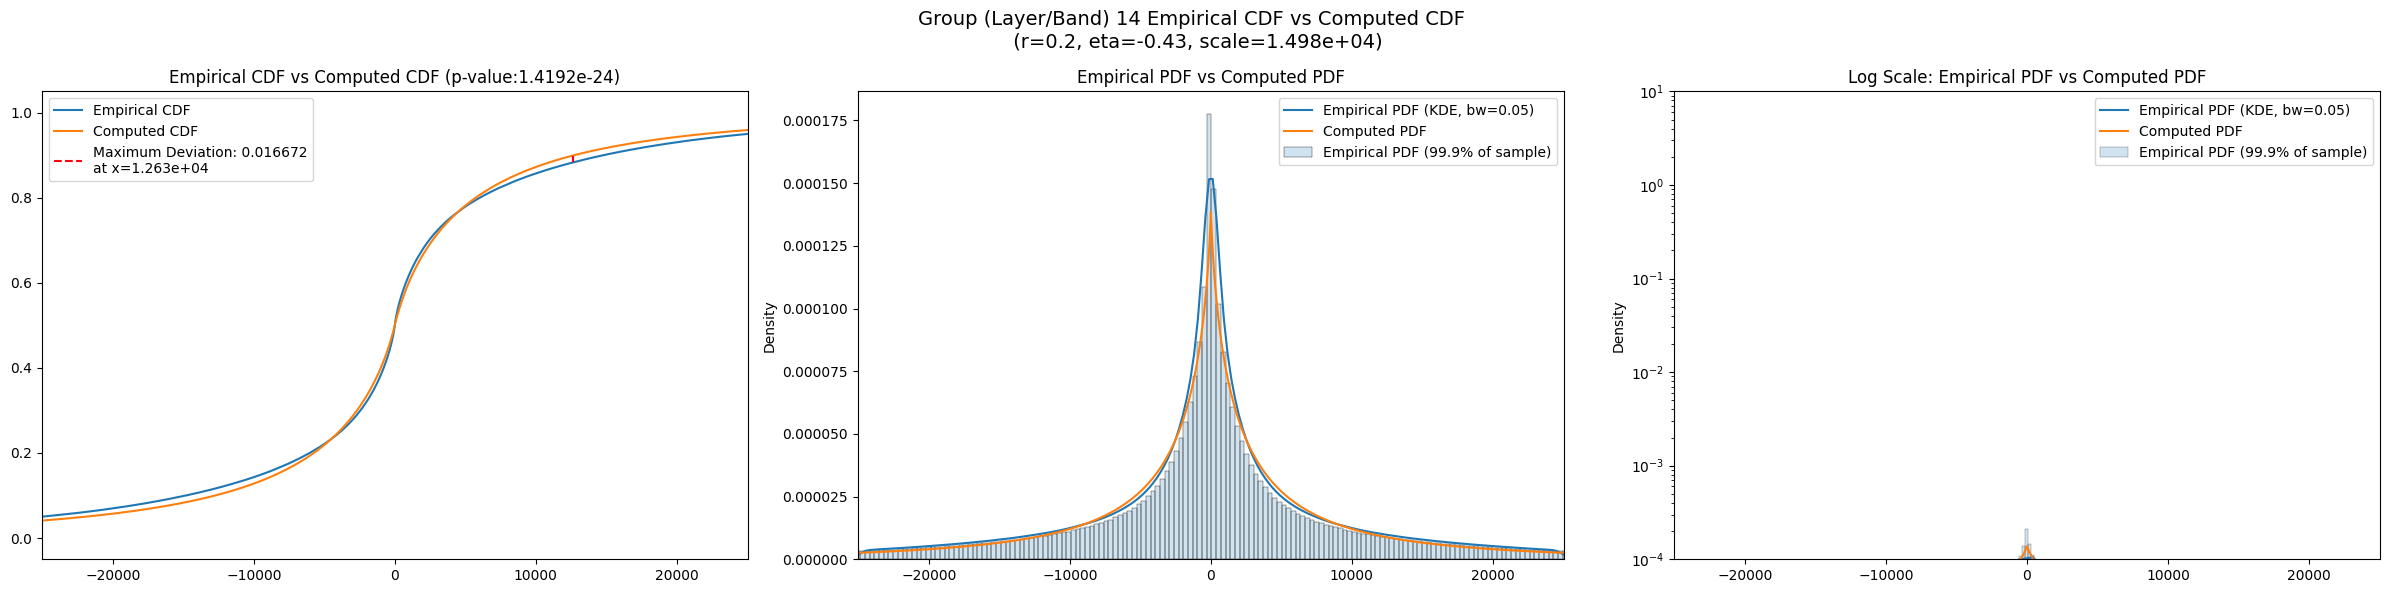

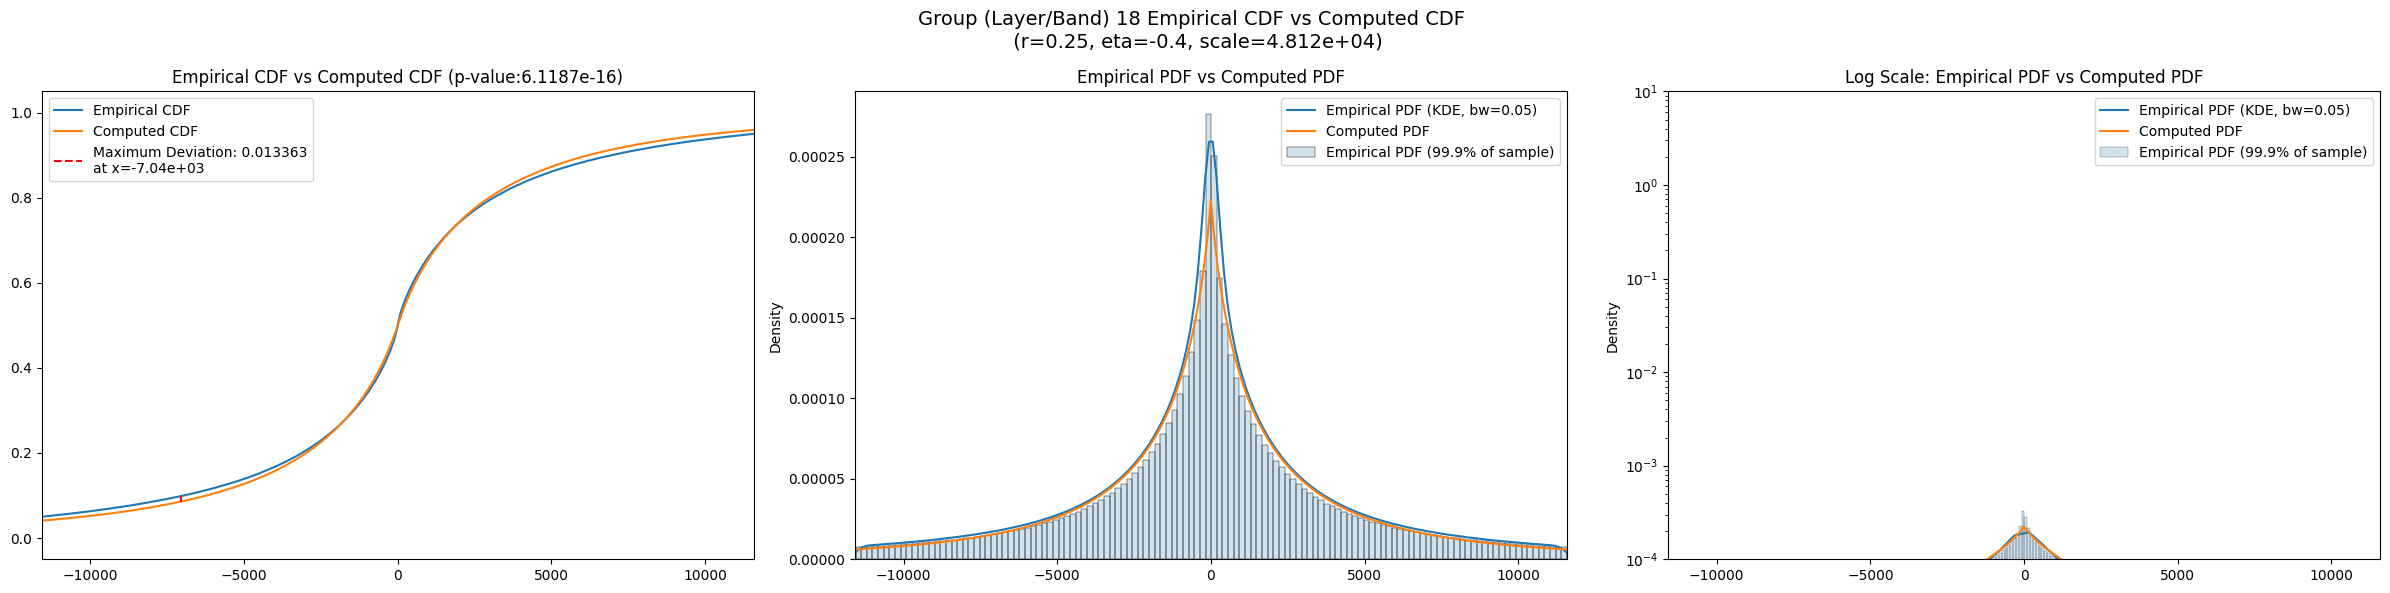

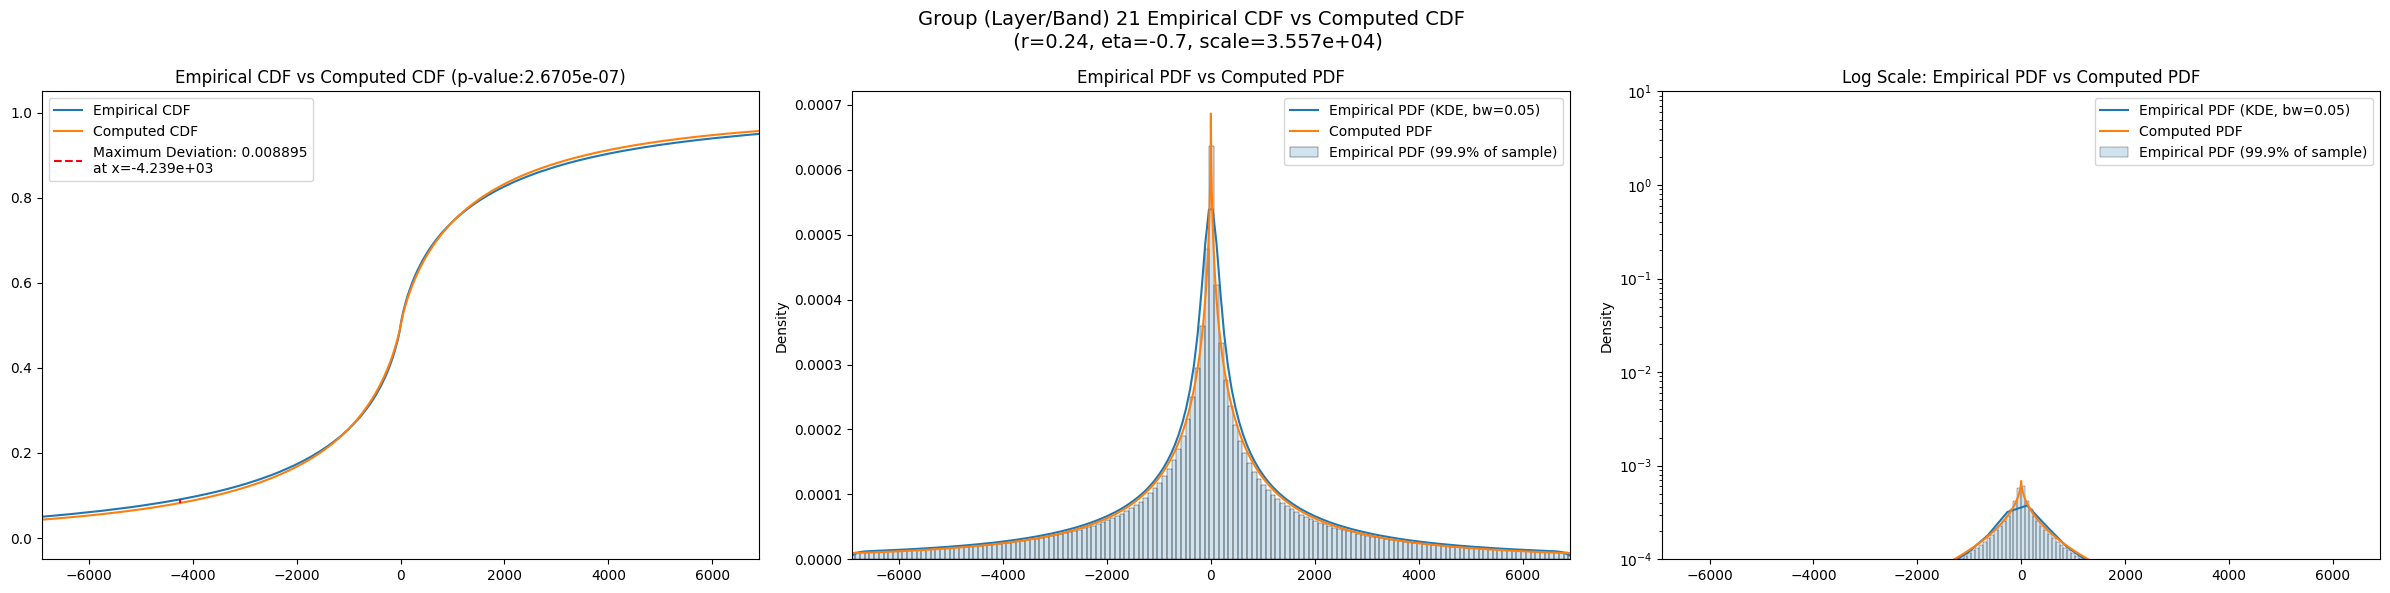

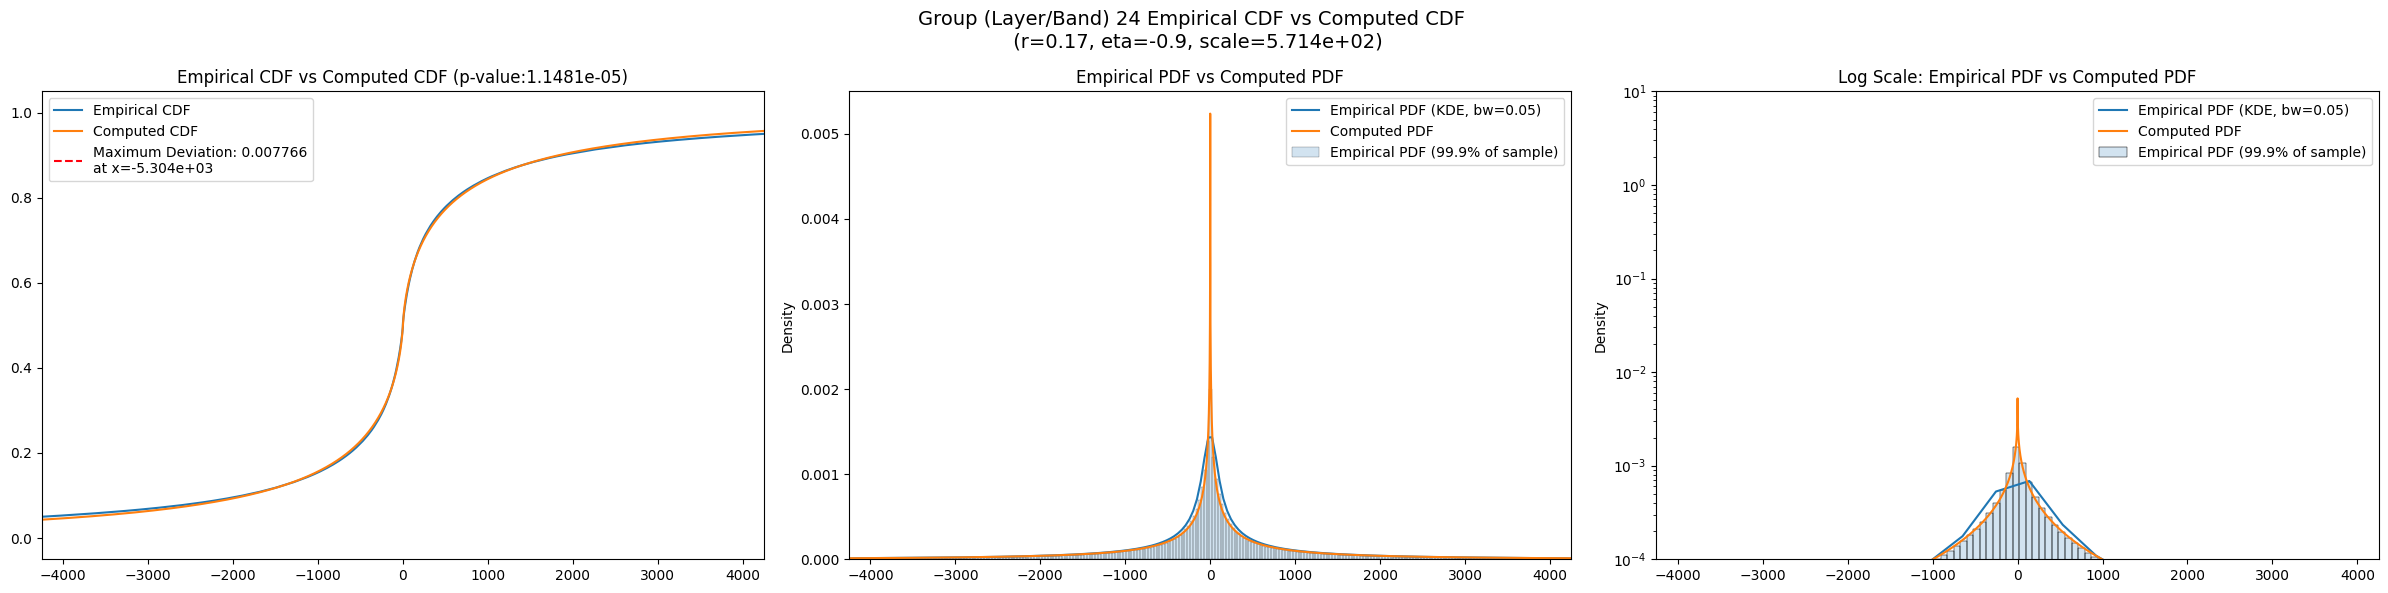

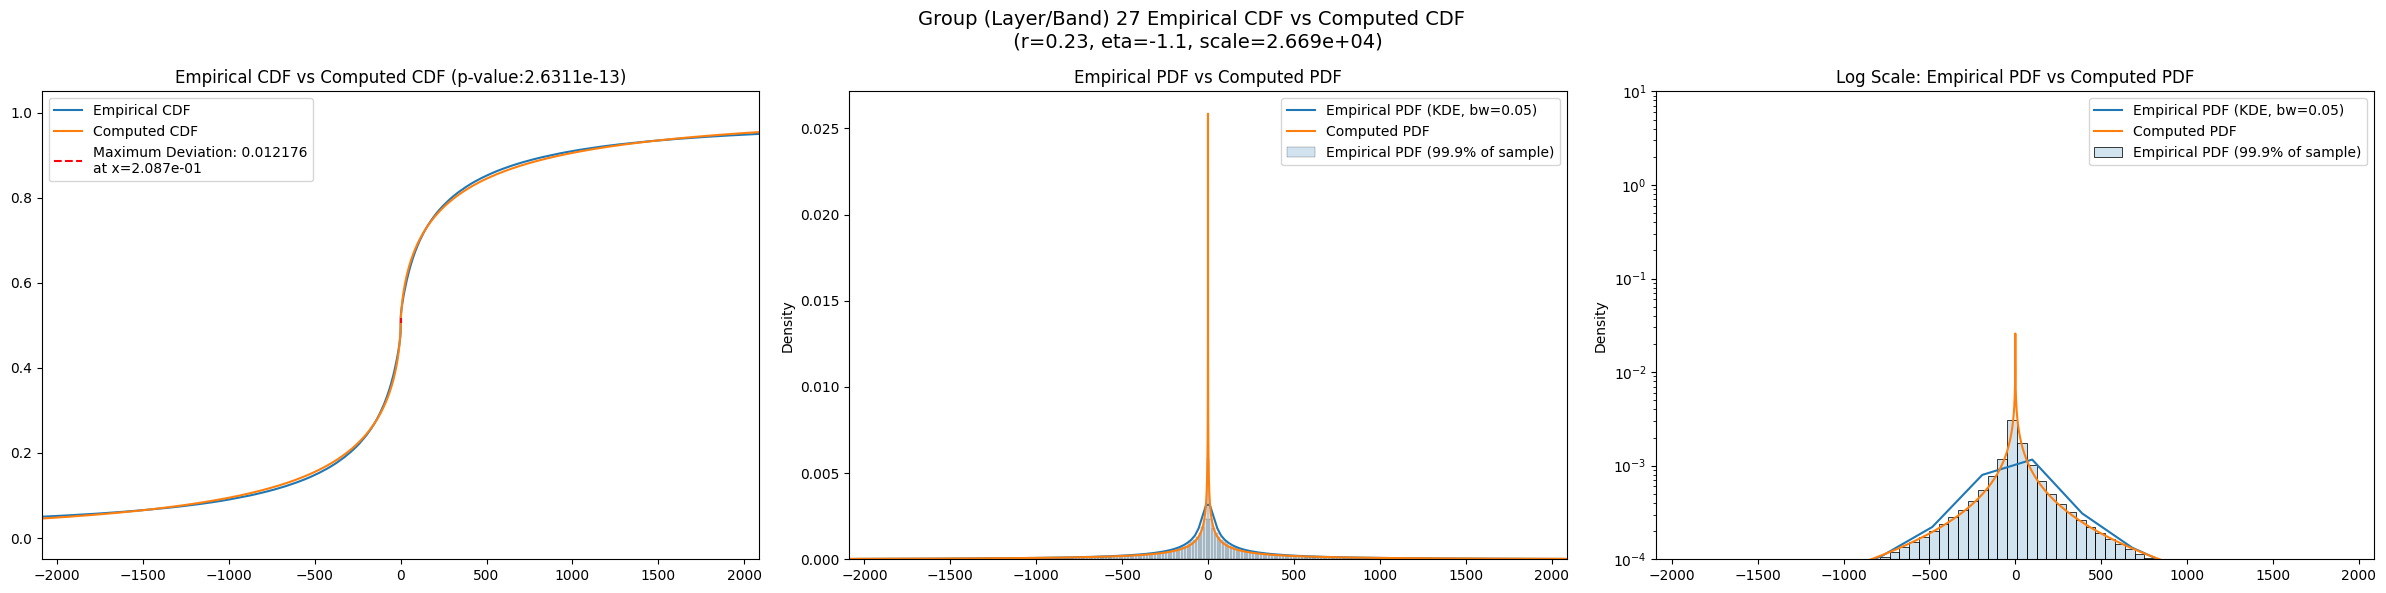

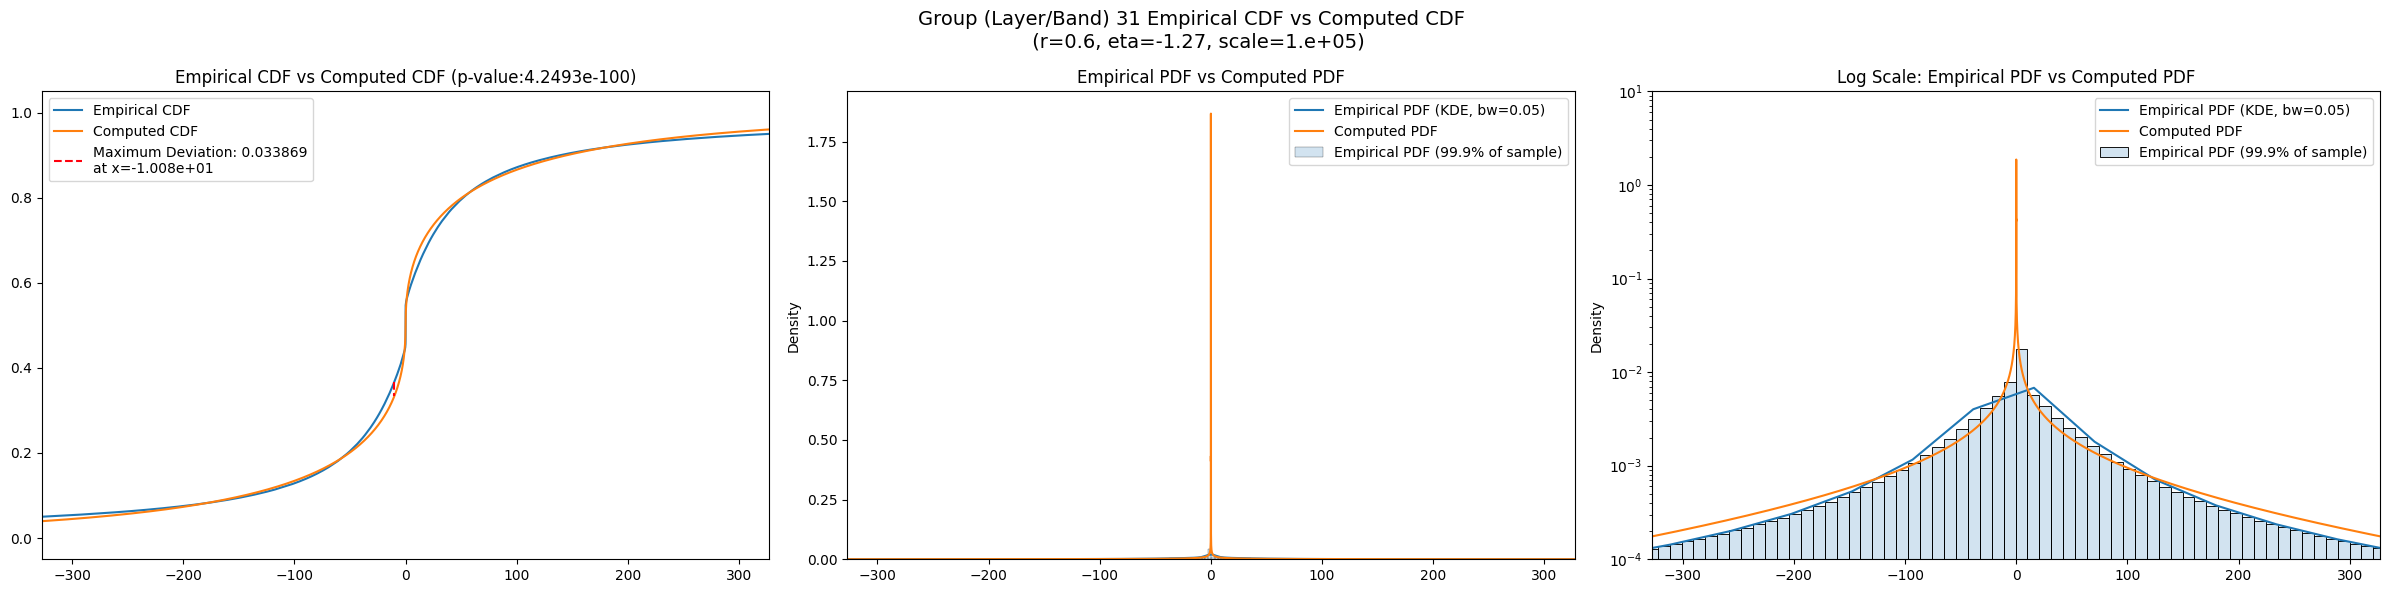

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     1.177774e+09  1.085649e+09  1.276239e+09   7.888103    6.781435   
5     2.880509e+09  2.718593e+09  3.046499e+09   2.915701    2.525911   
8     1.827356e+09  1.720742e+09  1.937364e+09   3.388295    2.926564   
11    1.390924e+09  1.312385e+09  1.470517e+09   2.917553    2.612940   
14    2.921197e+08  2.674729e+08  3.178738e+08   9.318104    8.035010   
18    5.415066e+07  4.980312e+07  5.888757e+07   8.531016    6.306366   
21    2.395606e+07  2.142995e+07  2.678720e+07  16.482788   11.398751   
24    1.826045e+07  1.571240e+07  2.106897e+07  30.356003   24.832960   
27    8.273984e+06  6.927880e+06  9.753366e+06  42.051674   34.199646   
31    2.400116e+05  1.916386e+05  3.022838e+05  75.993420   46.090584   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.279733     57824238.0             0.032395        0.1          0.2   
5       3.333546     57824238.0             0.026898        0.2          0.7   
8       3.872236     57824238.0             0.019617        0.2          0.8   
11      3.238348     57824238.0             0.029579        0.2          0.2   
14     10.718221     57824238.0             0.017915        0.2         -0.4   
18     12.651335     57824238.0             0.014995        0.2         -0.1   
21     25.385132     57824238.0             0.011161        0.2         -0.5   
24     36.771297     57824238.0             0.009661        0.2         -1.0   
27     51.289660     57824238.0             0.014169        0.2         -1.0   
31    178.931350     57824238.0             0.037668        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...      10943.1000              0.098109                   0.0   
5     ...      35763.6000              0.057123                   0.0   
8     ...      28807.1000              0.050908                   0.0   
11    ...      21767.1000              0.072355                   0.0   
14    ...       7572.1700              0.075360                   0.0   
18    ...       4010.0000              0.062471                   0.0   
21    ...       2048.2800              0.072149                   0.0   
24    ...        823.6780              0.089391                   0.0   
27    ...        391.7740              0.087865                   0.0   
31    ...         70.2967              0.078772                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2          9670.840             0.073380                  0.0   7364.4500   
5         30479.500             0.032984                  0.0  24849.3000   
8         24805.700             0.025139                  0.0  20300.2000   
11        18747.100             0.045981                  0.0  14954.5000   
14         6534.180             0.049157                  0.0   5142.2100   
18         3472.970             0.036073                  0.0   2731.2700   
21         1775.640             0.046365                  0.0   1381.2400   
24          723.810             0.065087                  0.0    548.3940   
27          343.604             0.063984                  0.0    258.6820   
31           60.842             0.056888                  0.0     44.3158   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.070887            0.0                   0.0  
5          0.038209            0.0                   0.0  
8          0.030633            0.0                   0.0  
11         0.048925            0.0                   0.0  
14         0.0509

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.032395                 0.000179          0.031580   
5                0.026898                 0.000179          0.026680   
8                0.019617                 0.000179          0.019447   
11               0.029579                 0.000179          0.028283   
14               0.017915                 0.000179          0.016672   
18               0.014995                 0.000179          0.013363   
21               0.011161                 0.000179          0.008895   
24               0.009661                 0.000179          0.007766   
27               0.014169                 0.000179          0.012187   
31               0.037668                 0.000179          0.033869   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.098109             0.073380       0.070887  
5                 0.057123             0.032984       0.038209  
8                 0.050908             0.025139       0.030633  
11                0.072355             0.045981       0.048925  
14                0.075360             0.049157       0.050943  
18                0.062471             0.036073       0.037927  
21                0.072149             0.046365       0.047152  
24                0.089391             0.065087       0.063194  
27                0.087865             0.063984       0.062267  
31                0.078772             0.056888       0.056439

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           1.177774e+09          0.031580    0.11      0.00       0.005939   
5           2.813727e+09          0.026680    0.22      0.50   56776.544501   
8           1.827356e+09          0.019447    0.23      0.50   72231.534489   
11          1.376875e+09          0.028283    0.22      0.00   82336.770130   
14          2.921197e+08          0.016672    0.20     -0.43   14984.694164   
18          5.415066e+07          0.013363    0.25     -0.40   48122.213122   
21          2.395606e+07          0.008895    0.24     -0.70   35566.374405   
24          1.635967e+07          0.007766    0.17     -0.90     571.373139   
27          4.055516e+06          0.012187    0.23     -1.10   26689.114498   
31          7.900981e+04          0.033869    0.60     -1.27  100000.000000   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    50.0  
8                     0.0  
11                   25.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                   50.0  
27                  425.0  
31                  600.0